# Предсказание температуры стали в установке ковш-печь для металлургического комбината

## Описание проекта

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Цель проекта:** предсказать финальную температуру стали, которая в дальнейшем позволит уменьшить потребление электроэнергии на этапе обработки стали. Метрика MAE должна быть меньше 6.8.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Целевой признак - измеренная температура.

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.



### План работы

1. Узучим информацию о представленных датасетах: данные об электродах, данные о подаче сыпучих и проволочных материалов (объём и время подачи), данные о продувке сплава газом и данные о результатах измерения температуры.
2. Подготовим данные: заполним пропуски, сформируем новые признаки.
3. Сформируем единую таблицу признаков.
4. Проверим признаки на кореляцию.
5. Разделим данные на тренировочную и тестовую выборку в соотношении 75:25
6. Проведем масштабирование данных.
7. Обучим модели и найдём их оптимальные параметры с помощью RamdomizedSearchCV. Модели: линейная регрессия, случайный лес, Catboost.
8. Выберем наилучшую модель. Проверим её на тестовой выборке.
9. Проведём анализ важности признаков.
10. Подготовим отчёт для заказчика.

### Подключим необходимые библиотеки

In [1]:
!pip3 install --upgrade --quiet --user pandas


!pip install skimpy
!pip install pipeline

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
skimpy 0.0.8 requires pandas<2.0.0,>=1.3.2, but you have pandas 2.1.3 which is incompatible.
  Using cached pandas-1.5.3-cp39-cp39-macosx_10_9_x86_64.whl (12.0 MB)


  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.3
    Uninstalling pandas-2.1.3:
      Successfully uninstalled pandas-2.1.3


In [2]:
pip install --upgrade dask

Note: you may need to restart the kernel to use updated packages.


In [3]:
# импорт библиотеки pandas
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items

# импорт библиотеки matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams, rcParamsDefault

# импорт библиотеки numpy
import numpy as np

# импорт библиотеки seaborn
import seaborn as sns



from skimpy import skim, clean_columns


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import make_scorer, mean_absolute_error, r2_score

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from IPython.display import HTML, display

!pip install lightgbm
from lightgbm import LGBMRegressor

!pip install catboost
from catboost import CatBoostRegressor

In [4]:
# библиотека warnings - отключение предупреждений
import warnings 
warnings.filterwarnings('ignore')


## Исследовательский анализ данных

### Загрузим данные

In [5]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv', sep=",", parse_dates=[1,2])
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv', sep=",")
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv', sep=",", parse_dates=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
ata_gas = pd.read_csv('/datasets/data_gas_new.csv', sep=",")
data_temp = pd.read_csv('/datasets/data_temp_new.csv', sep=",", parse_dates=[1])
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv', sep=",", parse_dates=[1,2,3,4,5,6,7,8,9])
    
    

### Изучим представленные данные.

**Данные об электродах**

In [6]:
display(data_arc.head())

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [7]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


**Данные о подаче сыпучих материалов (объём)**

In [8]:
display(data_bulk.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [9]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


**Данные о подаче сыпучих материалов (время)**

In [10]:
display(data_bulk_time.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [11]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


**Данные о продувке сплава газом**

In [12]:
display(data_gas.head())

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [13]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


**Результаты измерения температуры**

In [14]:
display(data_temp.head())

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [15]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


**Данные о проволочных материалах (объём)**

In [16]:
display(data_wire.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


**Данные о проволочных материалах (время)**

In [18]:
display(data_wire_time.head())

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [19]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB



 Данные и их формат выглядят достоверно. Для более точного понимания изучим каждый датафрейм подробнее.

#### Данные об электродах

In [20]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [21]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


**Переименуем признаки**

In [22]:
data_arc.columns=['key', 'start_of_arc_heating', 'end_of_arc_heating', 'active_power', 'reactive_power']

In [23]:
data_arc.head(5)

,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [24]:
data_arc.describe()

,key,active_power,reactive_power
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [25]:
skim(data_arc)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 14876  │ │ datetime64  │ 2     │                                                          │
│ │ Number of columns │ 5      │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name           ┃ NA   ┃ NA %    ┃ mean    ┃ sd      ┃ p0      ┃ p25    ┃ p75    ┃ p100   ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩  │
│ │ key                   │    0 │       0 │    1600 │     930 │       1 │    810 │   2400 │   3200 │  ██████  │  │
│ │ active_power          │    0 │       0 │    0.66 │    0.26 │    0.22 │   0.47 │   0.83 │    1.5 │  ▄█▅▃▂▁  │  │
│ │ reactive_power        │    0 │       0 │    0.44 │     5.9 │    -720 │   0.34 │   0.61 │    1.3 │       █  │  │
│ └───────────────────────┴──────┴─────────┴─────────┴─────────┴─────────┴────────┴────────┴────────┴──────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA  ┃ NA %   ┃ first                   ┃ last                    ┃ frequency   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩  │
│ │ start_of_arc_heating      │   0 │      0 │   2019-05-03 11:02:14   │   2019-09-06 17:24:54   │ None        │  │
│ │ end_of_arc_heating        │   0 │      0 │   2019-05-03 11:06:02   │   2019-09-06 17:26:15   │ None        │  │
│ └───────────────────────────┴─────┴────────┴─────────────────────────┴─────────────────────────┴─────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [26]:
# наличие дубликатов
data_arc.duplicated().sum()

0

In [27]:
# число партий в датасете
len(data_arc['key'].value_counts())

3214

* датасет содержит 14876 наблюдений по 5 признакам.
* максимальное значение номера партии 3241, следовательно каждая партия имеет по несколько измерений.
* пропусков в датасете нет. 
* дубликатов нет.
* наблюдаются выбросы: значение реактивной мощности не может быть отрицательным.





**Рассмотрим распределиение активной и реактивной мошностей.**

<function matplotlib.pyplot.show(close=None, block=None)>

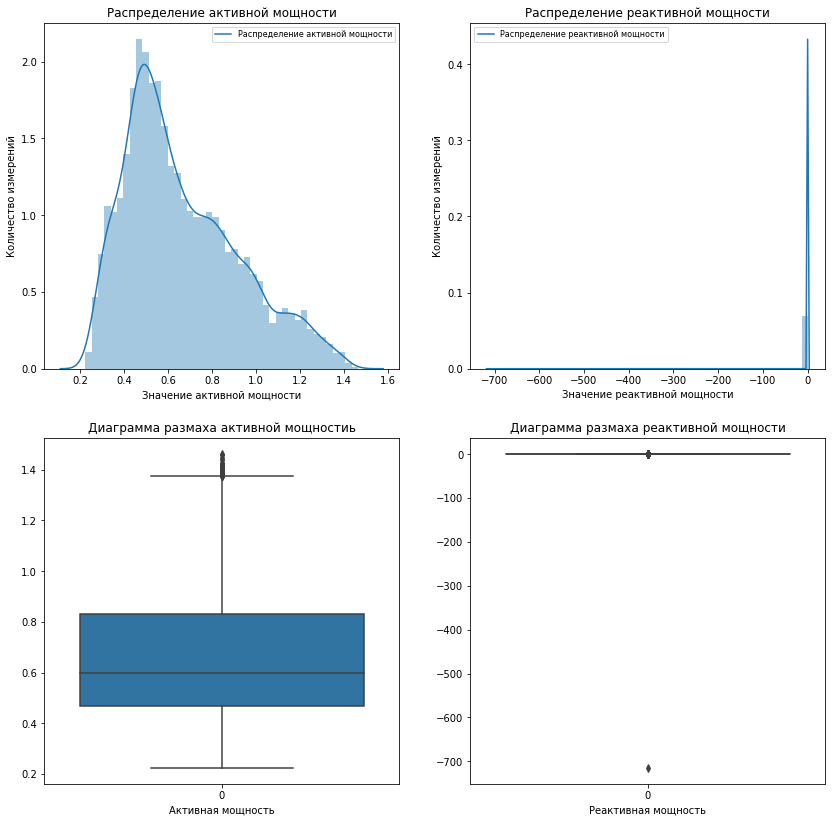

In [28]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,14))

sns.distplot(data_arc['active_power'], ax=ax[0,0] )
ax[0,0].set(title='Распределение активной мощности')
ax[0,0].set(xlabel='Значение активной мощности', ylabel='Количество измерений')
ax[0,0].legend(['Распределение активной мощности'], fontsize=8)


sns.distplot(data_arc['reactive_power'], ax=ax[0,1])
ax[0,1].set(title='Распределение реактивной мощности')
ax[0,1].set(xlabel='Значение реактивной мощности', ylabel='Количество измерений')
ax[0,1].legend(['Распределение реактивной мощности'], fontsize=8)

sns.boxplot(data=data_arc['active_power'], ax=ax[1,0])
ax[1,0].set(title='Диаграмма размаха активной мощностиь')
ax[1,0].set(xlabel='Активная мощность')

sns.boxplot(data=data_arc['reactive_power'], ax=ax[1,1])
ax[1,1].set(title='Диаграмма размаха реактивной мощности')
ax[1,1].set(xlabel='Реактивная мощность')
plt.show

Визуализация показывает нам, что в реактивной мощности содержится небольшое количество данных с выбросами в сторону отрицательного значения. Это мешает нам рассмотреть данные более внимательно.

Узнаем в каких партиях содержатся аномалии по реактивной мощности.

В выборке содержится только одно отрицательное значение в партии 2116. Рассмотрим значения реактивной мощности во всех измерениях этой партии.

In [30]:
# заначение мощностей в этой партии
data_arc.loc[data_arc['key']==2116]

,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


Отрицательное значение реактивной мощности является единичным выбросом. Это может быть связано с ошибкой измерительного оборудования или некорректным внесением данных. 

Удалим всю партию с выбросом.

In [31]:
print('Количество строк до удаления аномальной партии:', data_arc.shape[0])
data_arc.drop(data_arc.loc[data_arc['key']==2116].index, axis=0, inplace=True)
print('Количество строк после удаления аномальной партии:', data_arc.shape[0])

Количество строк до удаления аномальной партии: 14876
Количество строк после удаления аномальной партии: 14872


Удаление произведено корректно. Удалено 4 строки.

Повторно рассмотрим распределение.

<function matplotlib.pyplot.show(close=None, block=None)>

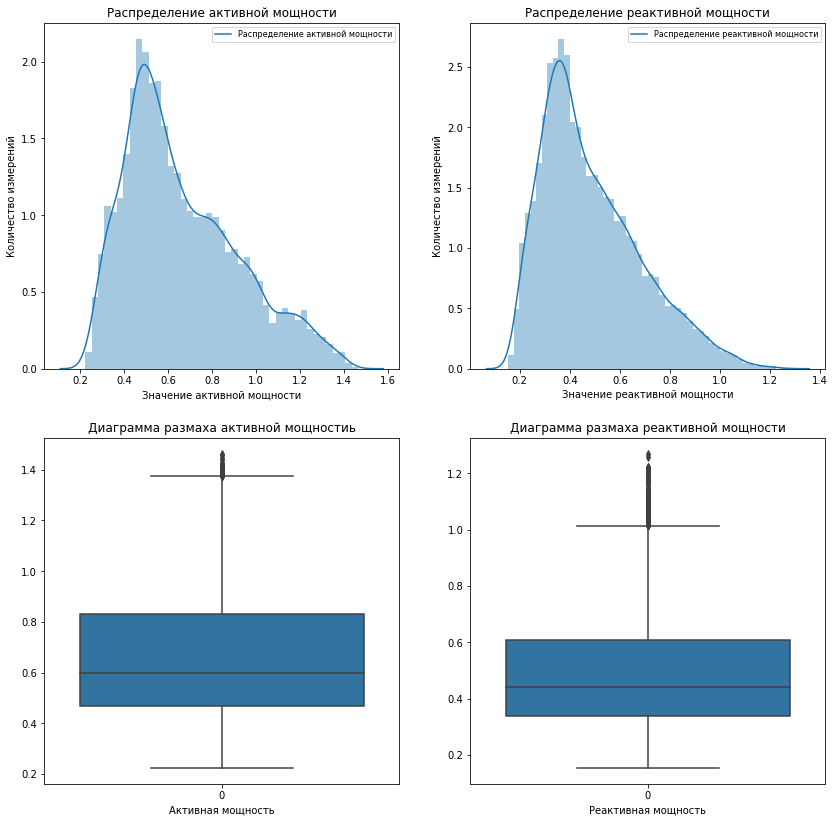

In [32]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,14))

sns.distplot(data_arc['active_power'], ax=ax[0,0] )
ax[0,0].set(title='Распределение активной мощности')
ax[0,0].set(xlabel='Значение активной мощности', ylabel='Количество измерений')
ax[0,0].legend(['Распределение активной мощности'], fontsize=8)


sns.distplot(data_arc['reactive_power'], ax=ax[0,1])
ax[0,1].set(title='Распределение реактивной мощности')
ax[0,1].set(xlabel='Значение реактивной мощности', ylabel='Количество измерений')
ax[0,1].legend(['Распределение реактивной мощности'], fontsize=8)

sns.boxplot(data=data_arc['active_power'], ax=ax[1,0])
ax[1,0].set(title='Диаграмма размаха активной мощностиь')
ax[1,0].set(xlabel='Активная мощность')

sns.boxplot(data=data_arc['reactive_power'], ax=ax[1,1])
ax[1,1].set(title='Диаграмма размаха реактивной мощности')
ax[1,1].set(xlabel='Реактивная мощность')
plt.show

После удаления аномального значения графики распределение близкое к нормальному.

Из физики известно, что активная и реактивная мощность являются взаимосвязанными значениями. Рассмотрим корреляцию этих значений.

In [33]:
corr_values = data_arc['active_power'].corr(data_arc['reactive_power'])
print('Коэффициент корреляции между активной и реактивной мошностями:', round(corr_values, 2))

Коэффициент корреляции между активной и реактивной мошностями: 0.97


Построим диаграмму рассеивания активной и реактивной мощностей

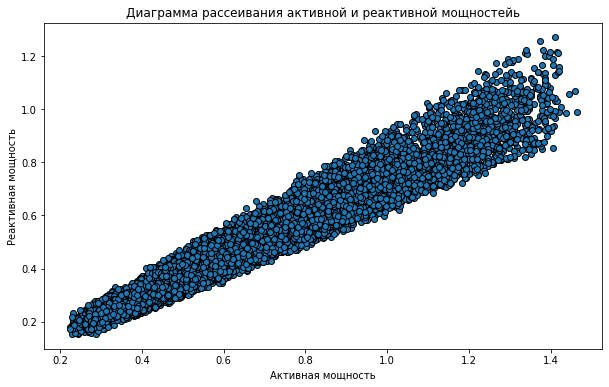

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(data_arc['active_power'], data_arc['reactive_power'],\
            edgecolors="black")
plt.title('Диаграмма рассеивания активной и реактивной мощностейь')
plt.xlabel('Активная мощность')
plt.ylabel('Реактивная мощность')


plt.show
None

Корреляция между активной и реактивной мощностями очень сильная: коэфиициент корреляции равен 0,97. Следовательно следует удалить один из этих признаков для того, что бы модели работали корректно и не переобучались или из данных признаков создать новый.

Из имеющихся данных мы можем создать следующие новые признаки:
- длительность нагрева (из время начала и время окончания нагрева дуги)
- полная мощность (квадратный корень из суммы квадратов активной и  реактривной мощностей)
- коэффициент мощности (отношение активной мощности к полной мощности)

**Создадим новые признаки.**

In [35]:
# время нагрева  в секундах
data_arc['heating_time'] = data_arc['end_of_arc_heating']-data_arc['start_of_arc_heating']
data_arc['heating_time'] = (data_arc['heating_time']/np.timedelta64(1,'s')).astype(int)

# полная мощность
data_arc['full_power'] = (data_arc['active_power']**2+data_arc['reactive_power']**2)**0.5

# коэффициент мощности
data_arc['power_factor'] = data_arc['active_power']/data_arc['full_power']

In [36]:
data_arc

,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power,heating_time,full_power,power_factor
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123,0.822181
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319,0.848545
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536,0.803161
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824,0.806591
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934,0.802950
...,...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157,0.532085,0.826438
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180,0.792429,0.815844
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184,1.293389,0.803877
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57,0.641792,0.826229


In [37]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   start_of_arc_heating  14872 non-null  datetime64[ns]
 2   end_of_arc_heating    14872 non-null  datetime64[ns]
 3   active_power          14872 non-null  float64       
 4   reactive_power        14872 non-null  float64       
 5   heating_time          14872 non-null  int64         
 6   full_power            14872 non-null  float64       
 7   power_factor          14872 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(2)
memory usage: 1.5 MB


In [38]:
data_arc.describe()

,key,active_power,reactive_power,heating_time,full_power,power_factor
count,14872.000000,14872.000000,14872.000000,14872.000000,14872.000000,14872.000000
mean,1615.085732,0.662753,0.487112,171.688004,0.823385,0.805890
std,934.661090,0.258916,0.197623,98.193604,0.323494,0.027655
min,1.000000,0.223120,0.153777,11.000000,0.275718,0.707722
25%,806.000000,0.467114,0.337175,107.000000,0.578813,0.788058
50%,1616.000000,0.599587,0.441667,147.000000,0.746591,0.809705
75%,2429.000000,0.830314,0.608201,214.000000,1.030390,0.827039
max,3241.000000,1.463773,1.270284,907.000000,1.898158,0.880503


Таким образом мы получили таблицу с 14872 записями по 8 признаков. Добавили следующие три признака:
- длительность нагрева 
- полная мощность 
- коэффициент мощности

**Количество прогревов в каждой партии**

Оценим распределение количества прогревов в партиях.

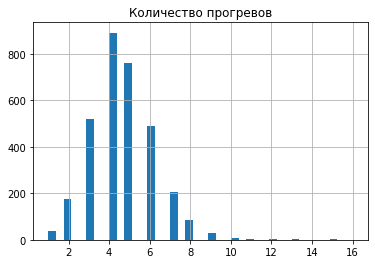

In [39]:
data_arc.groupby('key').count()['active_power'].hist(bins=40)
plt.title('Количество прогревов')
plt.show;

* Видно, что чаще всего используется 3-6 прогревов сплава. В редких случаях 14-16.

В имеющихся данных представлено по несколько измерений для каждой партии. Для предсказания температур нам необходимо сгруппировать по партиям. Так же уберём из таблицы признаки, которые нам больше не понадобятся: начало нагрева дуги -'start_of_arc_heating', конец нагрема дуги - 'end_of_arc_heating', активная мощность - 'active_power', реактивная мощность - 'reactive_power'.
Оставим следующие признаки:
- key - номер партии
- heating_time_sum -  суммарное время нагрева
- full_power_sum - суммарная полная мощность
- power_factor_mean - средний коэффициент мощности

In [40]:
data_arc_total = (data_arc.groupby('key').agg(heating_time_sum=('heating_time', 'sum'),
                                              full_power_sum=('full_power', 'sum'),
                                              power_factor_mean =('power_factor', 'mean')))

In [41]:
data_arc_total.head()

,heating_time_sum,full_power_sum,power_factor_mean
key,,,
1,1098,3.718736,0.816686
2,811,2.588349,0.825276
3,655,5.019223,0.809724
4,741,3.400038,0.793923
5,869,2.816980,0.796818


In [42]:
data_arc_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   heating_time_sum   3213 non-null   int64  
 1   full_power_sum     3213 non-null   float64
 2   power_factor_mean  3213 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 100.4 KB


### Данные о подаче сыпучих материалов объём

In [43]:
display(data_bulk.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Изменим заименования призкаков - приведём их к строчным.

In [44]:
data_bulk = clean_columns(data_bulk)

15 column names have been cleaned

In [45]:
display(data_bulk.head())

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [46]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [47]:
skim(data_bulk)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3129   │ │ float64     │ 15    │                                                          │
│ │ Number of columns │ 16     │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA      ┃ NA %    ┃ mean    ┃ sd     ┃ p0     ┃ p25    ┃ p75     ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ key                │       0 │       0 │    1600 │    930 │      1 │    820 │    2400 │    3200 │  ██████  │  │
│ │ bulk_1             │    2900 │      92 │      39 │     18 │     10 │     27 │      46 │     180 │   █▅▁    │  │
│ │ bulk_2             │    3100 │      99 │     250 │     21 │    230 │    240 │     260 │     320 │  ▅█▁▁ ▁  │  │
│ │ bulk_3             │    1800 │      59 │     110 │     75 │      6 │     58 │     150 │     450 │   █▇▃▁   │  │
│ │ bulk_4             │    2100 │      68 │     100 │     48 │     12 │     72 │     130 │     280 │  ▄██▃▁   │  │
│ │ bulk_5             │    3100 │      98 │     110 │     82 │     11 │     70 │     130 │     600 │   █▄▁    │  │
│ │ bulk_6             │    2600 │      82 │     120 │     72 │     17 │     70 │     160 │     500 │   █▆▂▁   │  │
│ │ bulk_7             │    3100 │      99 │     310 │    190 │     47 │    160 │     410 │     770 │  ▇▄█▃▂▁  │  │
│ │ bulk_8             │    3100 │     100 │      49 │    nan │     49 │     49 │      49 │      49 │      █   │  │
│ │ bulk_9             │    3100 │      99 │      76 │     22 │     63 │     66 │      70 │     150 │   █  ▁   │  │
│ │ bulk_10            │    3000 │      94 │      83 │     26 │     24 │     64 │     100 │     160 │  ▂▆██▂   │  │
│ │ bulk_11            │    3000 │      94 │      77 │     60 │      8 │     25 │     110 │     310 │   █▅▂▁   │  │
│ │ bulk_12            │     680 │      22 │     260 │    120 │     53 │    200 │     320 │    1800 │    █▂    │  │
│ │ bulk_13            │    3100 │      99 │     180 │     46 │    150 │    150 │     200 │     300 │  █▁▂ ▁▁  │  │
│ │ bulk_14            │     320 │      10 │     170 │     66 │     16 │    120 │     210 │     640 │   ▄█▂    │  │
│ │ bulk_15            │     880 │      28 │     160 │     52 │      1 │    100 │     200 │     400 │    ▇▃█   │  │
│ └────────────────────┴─────────┴─────────┴─────────┴────────┴────────┴────────┴─────────┴─────────┴──────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

У нас имеются признаки с большим количеством пропусков. Мы знаем, что если есть пропуск, то данный сыпучий материал не добaвлялся в эту партию.

Построим диаграмму размаха для сыпучих материалов.

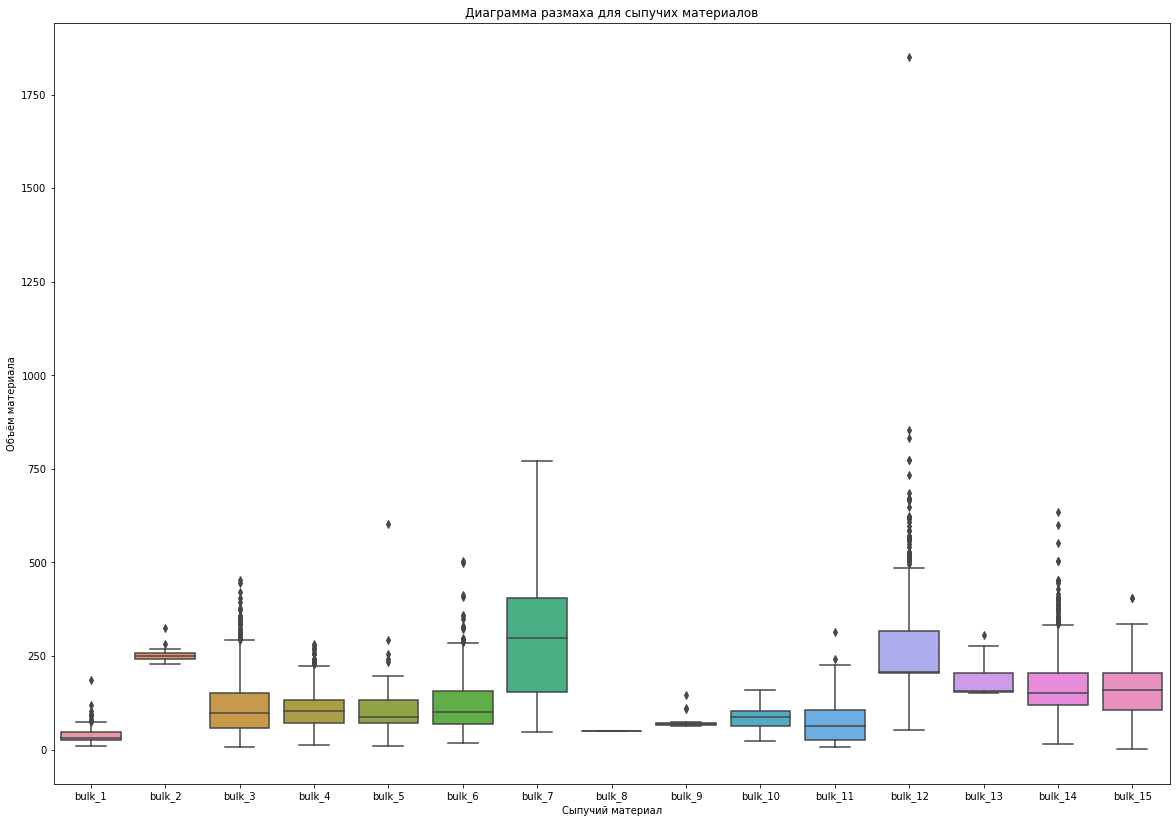

In [48]:
fig = plt.figure(figsize = (20,14))
sns.boxplot(data=data_bulk[data_bulk.columns[1:]])
plt.xlabel('Сыпучий материал')
plt.ylabel('Объём материала')
plt.title('Диаграмма размаха для сыпучих материалов')
plt.show()
None


По диаграмме размаха видно, что у нас присутствуют выбросы, но судить аномалия это или нет мы не можем  так как не обладаем точной информацией о химическом составе сыпуих материалов. Уберём только самые явные выбросы: ограничим bulk_12 значением 1000.

In [49]:
data_bulk.drop(data_bulk[data_bulk['bulk_12']>1000].index, axis=0, inplace=True)

Построим тепловую карту для сыпучих материалов, что бы понять как часто добавляестся тот или иной материал.

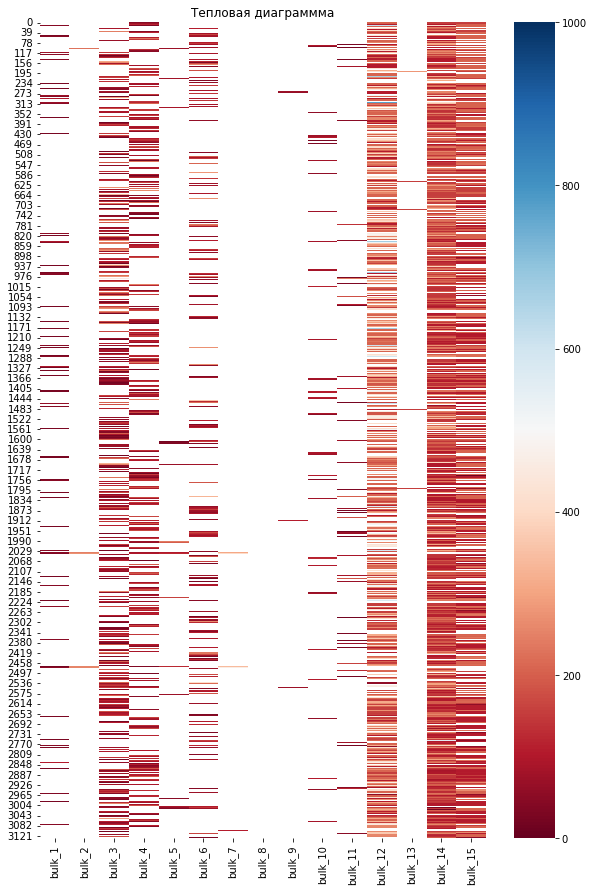

In [50]:
plt.figure(figsize=(10,15))
sns.heatmap(data_bulk.drop(columns = 'key'), vmax=1000, vmin=0, cmap='RdBu')
plt.title('Тепловая диаграммма')
plt.show()
None

Из тепловой диаграммы мы видем, что чаще всего используются материалы: bulk_12, bulk_14 и bulk_15. А реже всего bulk_7, bulk_9, bulk_8.

Заменим пропуски на нули.

In [51]:
data_bulk = data_bulk.fillna(0)
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3128 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3128 non-null   int64  
 1   bulk_1   3128 non-null   float64
 2   bulk_2   3128 non-null   float64
 3   bulk_3   3128 non-null   float64
 4   bulk_4   3128 non-null   float64
 5   bulk_5   3128 non-null   float64
 6   bulk_6   3128 non-null   float64
 7   bulk_7   3128 non-null   float64
 8   bulk_8   3128 non-null   float64
 9   bulk_9   3128 non-null   float64
 10  bulk_10  3128 non-null   float64
 11  bulk_11  3128 non-null   float64
 12  bulk_12  3128 non-null   float64
 13  bulk_13  3128 non-null   float64
 14  bulk_14  3128 non-null   float64
 15  bulk_15  3128 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 415.4 KB


In [52]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


### Данные о сыпучих материалах (время)

In [53]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


Изменим наименования призкаков - приведём их к строчным.

In [54]:
data_bulk_time = clean_columns(data_bulk_time)

15 column names have been cleaned

In [55]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


In [56]:
skim(data_bulk_time)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3129   │ │ datetime64  │ 15    │                                                          │
│ │ Number of columns │ 16     │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA    ┃ NA %     ┃ mean     ┃ sd     ┃ p0   ┃ p25    ┃ p75     ┃ p100    ┃ hist      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ key                 │     0 │        0 │     1600 │    930 │    1 │    820 │    2400 │    3200 │  ██████   │  │
│ └─────────────────────┴───────┴──────────┴──────────┴────────┴──────┴────────┴─────────┴─────────┴───────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA     ┃ NA %   ┃ first                      ┃ last                      ┃ frequency    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩  │
│ │ bulk_1           │   2900 │     92 │    2019-05-03 17:42:46     │    2019-09-05 09:11:32    │ None         │  │
│ │ bulk_2           │   3100 │     99 │    2019-05-07 15:39:35     │    2019-08-13 11:47:39    │ None         │  │
│ │ bulk_3           │   1800 │     59 │    2019-05-03 20:40:25     │    2019-09-06 12:26:52    │ None         │  │
│ │ bulk_4           │   2100 │     68 │    2019-05-03 11:28:48     │    2019-09-05 03:35:21    │ None         │  │
│ │ bulk_5           │   3100 │     98 │    2019-05-07 15:19:17     │    2019-09-02 18:16:52    │ None         │  │
│ │ bulk_6           │   2600 │     82 │    2019-05-03 19:09:15     │    2019-09-06 16:24:28    │ None         │  │
│ │ bulk_7           │   3100 │     99 │    2019-05-07 18:11:01     │    2019-09-05 19:07:49    │ None         │  │
│ │ bulk_8           │   3100 │    100 │    2019-07-08 17:14:53     │    2019-07-08 17:14:53    │ None         │  │
│ │ bulk_9           │   3100 │     99 │    2019-05-14 11:57:58     │    2019-08-16 09:11:56    │ None         │  │
│ │ bulk_10          │   3000 │     94 │    2019-05-06 07:54:02     │    2019-09-04 10:03:22    │ None         │  │
│ │ bulk_11          │   3000 │     94 │    2019-05-05 23:43:24     │    2019-09-06 05:03:14    │ None         │  │
│ │ bulk_12          │    680 │     22 │    2019-05-03 11:24:31     │    2019-09-06 15:01:44    │ None         │  │
│ │ bulk_13          │   3100 │     99 │    2019-05-05 02:10:21     │    2019-09-01 01:53:02    │ None         │  │
│ │ bulk_14          │    320 │     10 │    2019-05-03 11:14:50     │    2019-09-06 17:26:33    │ None         │  │
│ │ bulk_15          │    880 │     28 │    2019-05-03 11:10:43     │    2019-09-06 17:23:15    │ None         │  │
│ └──────────────────┴────────┴────────┴────────────────────────────┴───────────────────────────┴──────────────┘  │
╰────────────────────────────────────────────────────── 

Данные в таблице о сыпучих материалах (время) по своей структуре аналогичны данным из таблицы о сыпучих материалах (объём). Так как в своей работе мы не будем исследовать временные ряды, то оставим эту таблицу без изменений.

### Данные о продувке сплава газом

In [57]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Изменим название столбцов.

In [58]:
data_gas.columns = 'key', 'gas_1'

In [59]:
data_gas.head()

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [60]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


В данных у нас 3239 записей и 2 признака: 'key' - номер партии и 'gas_1' - объём газа

In [61]:
data_gas.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Построим график распределения и диаграмму размаха.

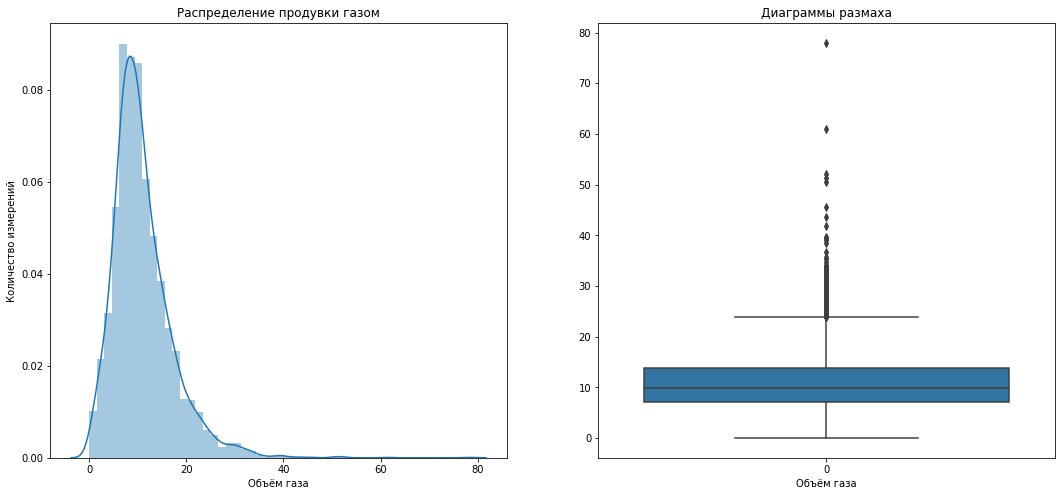

In [62]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,8))
ax[0].set(title='Распределение продувки газом')
sns.distplot(data_gas['gas_1'], ax=ax[0] )

ax[0].set(xlabel='Объём газа', ylabel='Количество измерений')

sns.boxplot(data=data_gas['gas_1'], ax=ax[1])
ax[1].set(xlabel='Объём газа')
ax[1].set(title='Диаграммы размаха')

plt.show
None

Проверим данные на наличие дубликатов:

In [63]:
data_gas.duplicated().sum()

0

Проанализировав данные о продувке сплава газом мы выяснили:
- пропусков в данных нет, газ использовался в каждой партии
- дубликатов нет
- в данных 3239 записей по 2 признака - номер партии и объём газа для продувки
- максимальное номер партии 3241
- данные имеют распределение близкое к нормальному. Есть значения значительно привышающие среднее, но принять решение о наличии анамалии мы не можем, так как не обладаем полной информацией


### Данные о результаты измерения температуры

In [64]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


Изменим названия признаков

In [65]:
data_temp.columns = 'key', 'measurement_time', 'temperature'

In [66]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               18092 non-null  int64         
 1   measurement_time  18092 non-null  datetime64[ns]
 2   temperature       14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [67]:
skim(data_temp)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 18092  │ │ int64       │ 1     │                                                          │
│ │ Number of columns │ 3      │ │ datetime64  │ 1     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA      ┃ NA %    ┃ mean    ┃ sd     ┃ p0      ┃ p25     ┃ p75     ┃ p100   ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━┩  │
│ │ key               │       0 │       0 │    1600 │    930 │       1 │     810 │    2400 │   3200 │  ██████  │  │
│ │ temperature       │    3400 │      19 │    1600 │     20 │    1200 │    1600 │    1600 │   1700 │      █▁  │  │
│ └───────────────────┴─────────┴─────────┴─────────┴────────┴─────────┴─────────┴─────────┴────────┴──────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓  │
│ ┃ column_name           ┃ NA   ┃ NA %   ┃ first                     ┃ last                     ┃ frequency   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩  │
│ │ measurement_time      │    0 │      0 │    2019-05-03 11:02:04    │   2019-09-06 17:30:05    │ None        │  │
│ └───────────────────────┴──────┴────────┴───────────────────────────┴──────────────────────────┴─────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [68]:
data_temp.describe()

,key,temperature
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


В данных 18092 записи. Есть пропуски в признаке 'temperature' - температура. 

Так как температура является для нас целевым признаком, исследуем этот параметр более внимательно.

In [69]:
print('Количество пропусков в признаке temperature:',  data_temp['temperature'].isna().sum())


Количество пропусков в признаке temperature: 3427


Изучим пропуски:

In [70]:
display(data_temp[data_temp['temperature'].isna()].head(15))

,key,measurement_time,temperature
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
13933,2501,2019-08-10 15:02:56,NaN
13934,2501,2019-08-10 15:07:47,NaN
13935,2501,2019-08-10 15:16:53,NaN
13936,2501,2019-08-10 15:22:50,NaN
13937,2501,2019-08-10 15:29:00,NaN


Построим график распределения температур и диаграмму размаха.

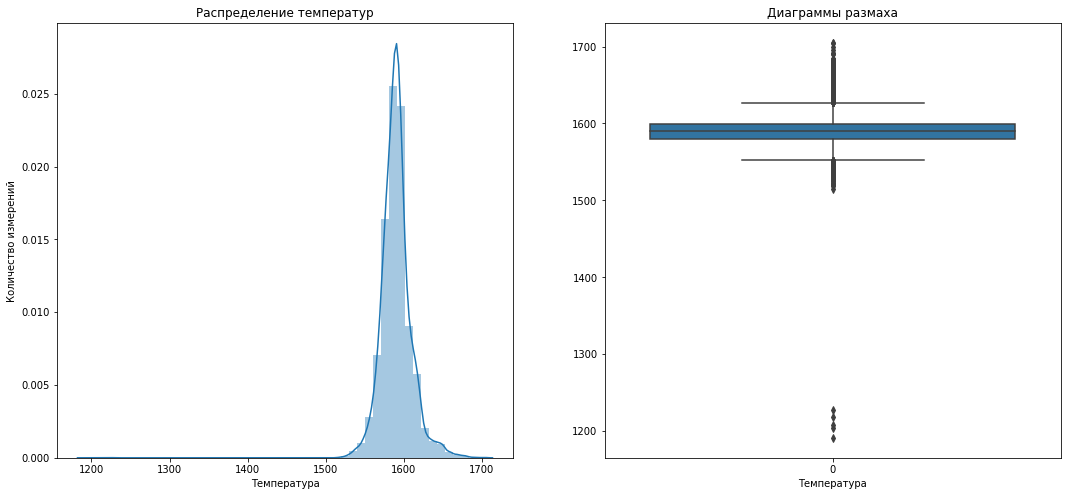

In [71]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,8))

sns.distplot(data_temp['temperature'], ax=ax[0] )
ax[0].set(title='Распределение температур')
ax[0].set(xlabel='Температура', ylabel='Количество измерений')

sns.boxplot(data=data_temp['temperature'], ax=ax[1])
ax[1].set(title='Диаграммы размаха')
ax[1].set(xlabel='Температура')

plt.show
None

In [72]:
# наличие дубликатов
data_temp.duplicated().sum()

0

Проведя анализ данных мы видем:
- в данных содержится 18092 записей по 3 признака: 'key' - партия, 'measurement_time' - время измерения и 'temperature' - температура.
- в данных содержится наш целевой признак - последняя температура измерения. Промежуточные температуры нам не понадобятся. Из первой измеренной температуры создадим новый признак. 
- выборка содержит 3427 пропуска в признаке 'temperature'. Партии содержащие только одно значение температуры и удалим из данных
- График распределения температур и диаграмма размаха наглядно показыает, что распределение температур близко в нормальному с хвостом уходящим влево. По требованиям заказчика, необходимо удалить все измерения, где температура ниже 1500 градусов.

Удалим строки с значением температур ниже 1500 градусов.

In [73]:
data_temp.drop(data_temp[data_temp['temperature']<1500].index, axis=0, inplace=True)

In [74]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18087 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               18087 non-null  int64         
 1   measurement_time  18087 non-null  datetime64[ns]
 2   temperature       14660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 565.2 KB


Построим график распределения температур и диаграмму размаха ещё раз.

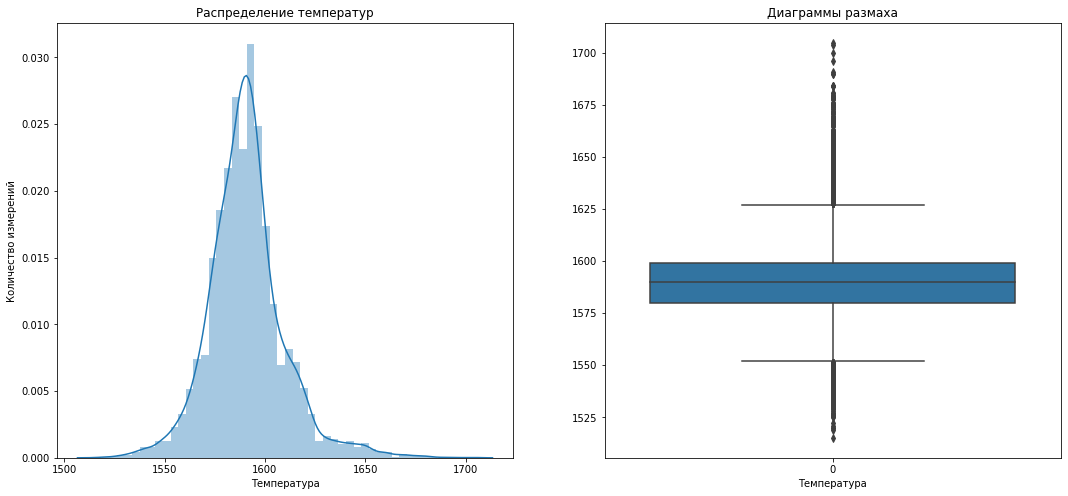

In [75]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,8))

sns.distplot(data_temp['temperature'], ax=ax[0] )
ax[0].set(title='Распределение температур')
ax[0].set(xlabel='Температура', ylabel='Количество измерений')

sns.boxplot(data=data_temp['temperature'], ax=ax[1])
ax[1].set(title='Диаграммы размаха')
ax[1].set(xlabel='Температура')

plt.show
None

**Создадим новые признаки: целевой признак  - последняя температура и признак - начальная температура**

In [76]:
# отсортируем занные по номеру партии и времени измерения
data_temp= data_temp.sort_values(by=['key', 'measurement_time'])

In [77]:
data_temp.head(20)

,key,measurement_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [78]:
data_temp.tail(20)

,key,measurement_time,temperature
18072,3239,2019-09-06 14:22:49,NaN
18073,3239,2019-09-06 14:28:54,NaN
18074,3239,2019-09-06 14:33:34,NaN
18075,3239,2019-09-06 14:42:48,NaN
18076,3239,2019-09-06 14:56:58,NaN
18077,3239,2019-09-06 14:59:25,NaN
18078,3239,2019-09-06 15:03:35,NaN
18079,3239,2019-09-06 15:09:55,NaN
18080,3240,2019-09-06 15:25:21,1617.0
18081,3240,2019-09-06 15:30:52,NaN


In [79]:
# группаируем данные по номеру партии и выделяем новые признаки: количество измерений, первая и последняя температуры
data_temp_total = data_temp.groupby('key').agg(count=('key', 'count'),
                                               temperature_start=('temperature', 'first'),
                                               temperature_finish=('temperature','last'))


In [80]:
data_temp_total.head()

,count,temperature_start,temperature_finish
key,,,
1,6,1571.0,1613.0
2,5,1581.0,1602.0
3,6,1596.0,1599.0
4,5,1601.0,1625.0
5,5,1576.0,1602.0


In [81]:
data_temp_total.tail()

,count,temperature_start,temperature_finish
key,,,
3237,6,1569.0,1569.0
3238,4,1584.0,1584.0
3239,9,1598.0,1598.0
3240,6,1617.0,1617.0
3241,6,1586.0,1586.0


In [82]:
data_temp_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 1 to 3241
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   count               3216 non-null   int64  
 1   temperature_start   3215 non-null   float64
 2   temperature_finish  3215 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 100.5 KB


In [83]:
data_temp_total.describe()

,count,temperature_start,temperature_finish
count,3216.000000,3215.000000,3215.000000
mean,5.624067,1589.195023,1594.049767
std,1.612982,25.015034,18.649454
min,1.000000,1519.000000,1529.000000
25%,5.000000,1572.000000,1585.000000
50%,5.000000,1588.000000,1593.000000
75%,7.000000,1606.000000,1600.000000
max,17.000000,1684.000000,1700.000000


Удалим из полученных данных партии с пропусками, а так же партии, где значения начальной и конечной температур одинаковые (это означает, что в данной партии проводилось только одно измерение).

In [84]:
data_temp_total= data_temp_total.dropna()

In [85]:
data_temp_total.describe()

,count,temperature_start,temperature_finish
count,3215.000000,3215.000000,3215.000000
mean,5.624261,1589.195023,1594.049767
std,1.613195,25.015034,18.649454
min,1.000000,1519.000000,1529.000000
25%,5.000000,1572.000000,1585.000000
50%,5.000000,1588.000000,1593.000000
75%,7.000000,1606.000000,1600.000000
max,17.000000,1684.000000,1700.000000


In [86]:
data_temp_total.drop(
    data_temp_total[data_temp_total['temperature_start']==data_temp_total['temperature_finish']].index,
    axis=0, inplace=True)

In [87]:
data_temp_total.tail()

,count,temperature_start,temperature_finish
key,,,
2495,5,1570.0,1591.0
2496,7,1554.0,1591.0
2497,4,1571.0,1589.0
2498,6,1591.0,1594.0
2499,5,1569.0,1603.0


In [88]:
data_temp_total= data_temp_total[['temperature_start', 'temperature_finish']]

In [89]:
data_temp_total.head()

,temperature_start,temperature_finish
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


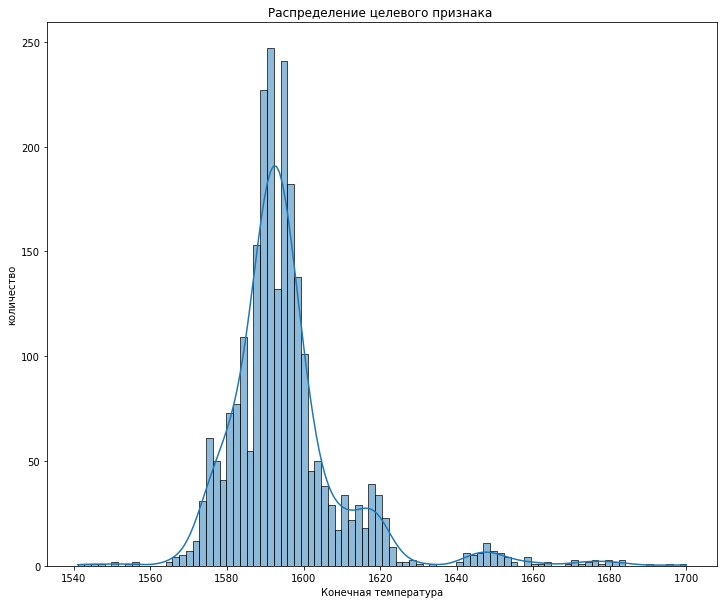

In [90]:
fig, axis = plt.subplots( figsize=(12,10))
sns.histplot(x=data_temp_total['temperature_finish'], kde=True)
plt.title('Распределение целевого признака ')
plt.xlabel('Конечная температура')
plt.ylabel('количество')
plt.show()
None

- Из данных мы получили целевой признак и новый признак - начальная температура.
- Целевой признак (конечная температура) имеет распределение близкое к нормальному


### Данные о проволочных материалах (объём)

In [91]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Изменим заименования призкаков - приведём их к строчным.

In [92]:
data_wire = clean_columns(data_wire)

9 column names have been cleaned

In [93]:
display(data_wire.head())

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [95]:
skim(data_wire)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3081   │ │ float64     │ 9     │                                                          │
│ │ Number of columns │ 10     │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA      ┃ NA %    ┃ mean    ┃ sd     ┃ p0       ┃ p25   ┃ p75     ┃ p100    ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ key               │       0 │       0 │    1600 │    930 │        1 │   820 │    2400 │    3200 │  ██████  │  │
│ │ wire_1            │      26 │    0.84 │     100 │     42 │      1.9 │    72 │     130 │     330 │   ▂█▅▁   │  │
│ │ wire_2            │    2000 │      65 │      51 │     39 │     0.03 │    20 │      70 │     280 │   █▄▁    │  │
│ │ wire_3            │    3000 │      98 │     190 │    100 │     0.14 │    95 │     280 │     390 │  ▂█ ▆█▁  │  │
│ │ wire_4            │    3100 │     100 │      57 │     29 │       24 │    41 │      76 │     110 │  ▅█▃▂▂▃  │  │
│ │ wire_5            │    3100 │     100 │      15 │    nan │       15 │    15 │      15 │      15 │      █   │  │
│ │ wire_6            │    3000 │      98 │      48 │     34 │    0.034 │    25 │      64 │     180 │  ▇█▄▁▁   │  │
│ │ wire_7            │    3100 │     100 │      10 │    8.6 │     0.23 │   6.8 │      12 │      33 │  ▆█▆  ▂  │  │
│ │ wire_8            │    3100 │      99 │      54 │     17 │       45 │    46 │      48 │     100 │  █ ▁  ▁  │  │
│ │ wire_9            │    3100 │      99 │      34 │     20 │      4.6 │    22 │      44 │      90 │  ▆█▅▃▃▁  │  │
│ └───────────────────┴─────────┴─────────┴─────────┴────────┴──────────┴───────┴─────────┴─────────┴──────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

У нас имеются признаки с большим количеством пропусков. Мы знаем, что если есть пропуск, то данный вид проволки не добовлялся в эту партию.

Построим диаграмму размаха для проволки.

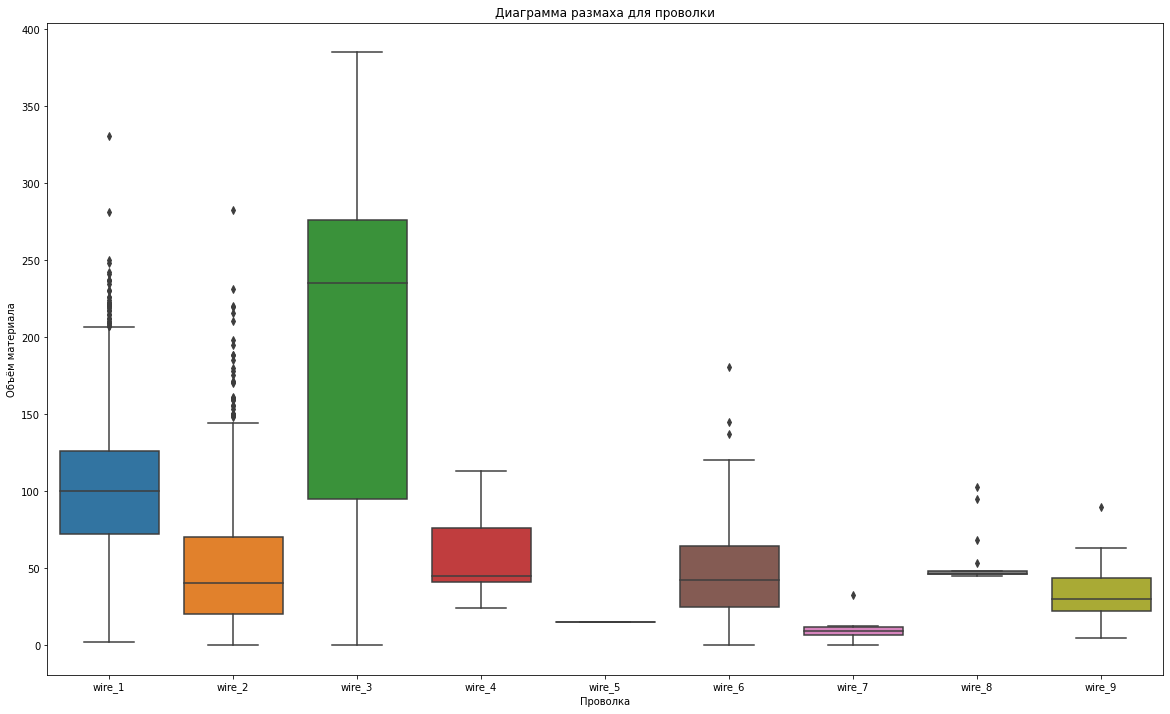

In [96]:
fig = plt.figure(figsize = (20,12))
sns.boxplot(data=data_wire[data_wire.columns[1:]])
plt.title('Диаграмма размаха для проволки')
plt.xlabel('Проволка')
plt.ylabel('Объём материала')
plt.show()
None


По диаграмме размаха видно, что у нас присутствуют выбросы, но судить аномалия это или нет мы не можем.

Построим темпераурную карту для проволки, что бы понять как часто добавляестся тот или иной её вид.

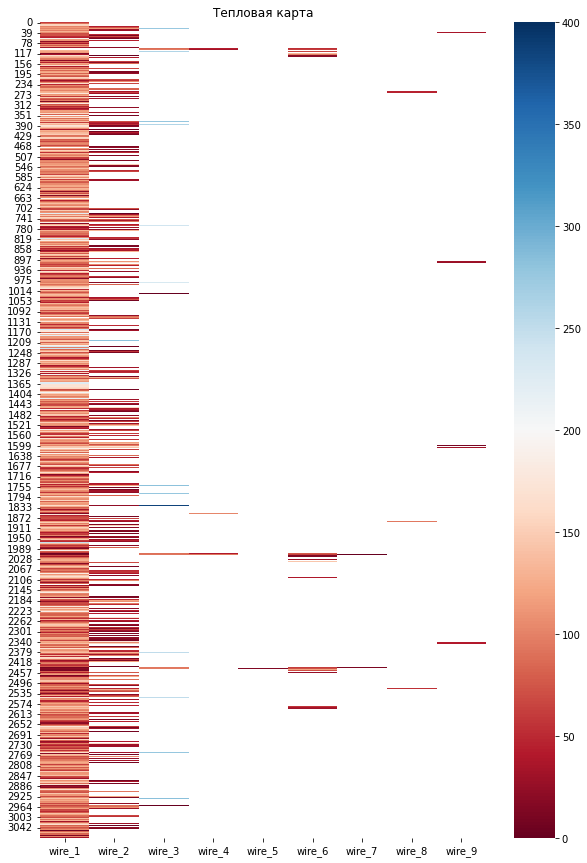

In [97]:
plt.figure(figsize=(10,15))
sns.heatmap(data_wire.drop(columns = 'key'), vmax=400, vmin=0, cmap='RdBu')
plt.title('Тепловая карта')
plt.show()
None

Из тепловой диаграммы мы видем, что чаще всего используются материалы: wire_1 и wire_2. А реже всего wire_5

Заменим пропуски на нули.

In [98]:
data_wire = data_wire.fillna(0)
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [99]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Данные о проволочных материалах (время)

In [100]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Изменим заименования призкаков - приведём их к строчным.

In [101]:
data_wire_time = clean_columns(data_wire_time)

9 column names have been cleaned

In [102]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


In [103]:
skim(data_wire_time)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3081   │ │ datetime64  │ 9     │                                                          │
│ │ Number of columns │ 10     │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA    ┃ NA %     ┃ mean     ┃ sd     ┃ p0   ┃ p25    ┃ p75     ┃ p100    ┃ hist      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ key                 │     0 │        0 │     1600 │    930 │    1 │    820 │    2400 │    3200 │  ██████   │  │
│ └─────────────────────┴───────┴──────────┴──────────┴────────┴──────┴────────┴─────────┴─────────┴───────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA     ┃ NA %   ┃ first                      ┃ last                      ┃ frequency    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩  │
│ │ wire_1           │     26 │   0.84 │    2019-05-03 11:06:19     │    2019-09-06 17:10:06    │ None         │  │
│ │ wire_2           │   2000 │     65 │    2019-05-03 13:15:34     │    2019-09-06 07:35:40    │ None         │  │
│ │ wire_3           │   3000 │     98 │    2019-05-04 04:34:27     │    2019-09-02 07:14:44    │ None         │  │
│ │ wire_4           │   3100 │    100 │    2019-05-07 15:19:17     │    2019-08-13 03:16:45    │ None         │  │
│ │ wire_5           │   3100 │    100 │    2019-08-13 06:14:30     │    2019-08-13 06:14:30    │ None         │  │
│ │ wire_6           │   3000 │     98 │    2019-05-07 14:46:05     │    2019-08-18 19:10:56    │ None         │  │
│ │ wire_7           │   3100 │    100 │    2019-07-27 05:49:05     │    2019-08-13 10:25:22    │ None         │  │
│ │ wire_8           │   3100 │     99 │    2019-05-14 11:29:24     │    2019-08-16 08:56:23    │ None         │  │
│ │ wire_9           │   3100 │     99 │    2019-05-04 17:21:27     │    2019-09-03 12:55:23    │ None         │  │
│ └──────────────────┴────────┴────────┴────────────────────────────┴───────────────────────────┴──────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

Данные в таблице о проволочных материалах (время) по своей структуре аналогичны данным из таблицы о проволочных материалах (объём). Так как в своей работе мы не будем исследовать временные ряды, то оставим эту таблицу без изменений.

### Вывод

1. Мы провели анализ предоставленных нам данных: данные об электродах, данные о подаче сыпучих и проволочных материалов (объём и время подачи), данные о продувке сплава газом и данные о результатах измерения температуры. 
2. Данные и их формат выглядят достоверно.
3. Привели названия признаков к надлежащему виду: латиница, строчные буквы
4. Данные об электродах:
- Были обнаружены и удалены анамальные значения для реактивной мощности - были удалены полностью партии в которых встречались аномальные значения.
- Получены графики распределения активной и реактивной мощностей. Их распределение близко к нормальному.
- Была выявлена корреляция между активной и реактивной мощностями: коэфиициент корреляции равен 0,97.
- Из имеющихся данных были созданы новые признаки:
   - длительность нагрева (из время начала и время окончания нагрева дуги)
   - полная мощность (квадратный корень из суммы квадратов активной и  реактривной мощностей)
   - коэффициент мощности (отношение активной мощности к полной мощности)
- В имеющихся данных было представлено по несколько измерений для каждой партии. Для предсказания температур нам было необходимо сгруппировать данные по партиям. 
- Из данных были удалены признаки, которые нам не нужны для предсказания: начало нагрева дуги -'start_of_arc_heating', конец нагрема дуги - 'end_of_arc_heating', активная мощность - 'active_power', реактивная мощность - 'reactive_power'. - Мы получили новую таблицу с 3213 записями по 4 признакам:
    - key - номер партии
    - heating_time_sum - суммарное время нагрева
    - full_power_sum - суммарная полная мощность
    - power_factor_mean - средний коэффициент мощности

- Пропусков и дубликатов в данных нет.

5. Данные о подаче сыпучих материалов (оъём)
- В данных было обнаружено большое количество пропусков.
- Пропуски были заиенены значением 0.
- По тепловой диаграмме определили, что чаще всего используются материалы: bulk_12, bulk_14 и bulk_15. А реже всего bulk_7, bulk_9, bulk_8.

6. Данные о подаче сыпучих материалов (время)
- Данные в таблице о сыпучих материалах (время) по своей структуре аналогичны данным из таблицы о сыпучих материалах (объём). 
- В работе мы не будем исследовать временные ряды, поэтому  оставили эти данные без изменений.

7. Данные о продувке сплава газом:
- пропусков в данных нет, газ использовался в каждой партии
- дубликатов нет
- в данных 3229 записей по 2 признака - номер партии и объём газа для продувки
- данные имеют распределение близкое к нормальному. Есть значения значительно привышающие среднее, но принять решение о наличии анамалии мы не можем, так как не обладаем полной информацией

8. Данные о результаты измерения температуры:
- В данных содержалось 18092 записей по 3 признака: 'key' - партия, 'measurement_time' - время измерения и 'temperature' - температура.
- Были обнаружены 3427 пропуска в признаке 'temperature' - температура.
- В данных содержалась информация о нашем целевом признаке - конечная температура.
- Были обнаружены и удалены выбросы - температура меньше 1500 градусов
- Был создан новый датафрейм с новыми признаками: целевой признак - последняя температура и признак - начальная температура
- Целевой признак (конечная температура) имеет распределение близкое к нормальному.
 
9. Данные подготовлены для объединения датафреймов в финальную таблицу.



**Вопросов по данным нет.**


## Модель

### Финальная таблица

Для создания финальной таблицы объединим имеющиеся у нас таблицы в одну по ключу: так что в датасет войдут только те ключи, которые есть во всех таблицах: data_arc_total, data_bulk, data_gas, data_temp_total, data_wire. Датасеты с временными данными включать не будем.

In [104]:
pd.set_option('display.max_columns', None)

In [105]:
data_total = data_arc_total.merge(data_bulk, on='key', how='inner')
data_total = data_total.merge(data_gas, on='key', how='inner')
data_total = data_total.merge(data_temp_total, on='key', how='inner')
data_total = data_total.merge(data_wire, on='key', how='inner')

data_total.head()



,key,heating_time_sum,full_power_sum,power_factor_mean,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1,temperature_start,temperature_finish,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1098,3.718736,0.816686,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,1571.0,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,811,2.588349,0.825276,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1581.0,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,655,5.019223,0.809724,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1596.0,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,741,3.400038,0.793923,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,1601.0,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,869,2.816980,0.796818,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,1576.0,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
data_total.tail()

,key,heating_time_sum,full_power_sum,power_factor_mean,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1,temperature_start,temperature_finish,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
2285,2495,723,3.868721,0.812727,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,1570.0,1591.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2286,2496,940,5.070316,0.819606,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,1554.0,1591.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2287,2497,569,4.360918,0.827613,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,1571.0,1589.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2288,2498,750,3.909917,0.819245,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,1591.0,1594.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2289,2499,883,2.169252,0.800782,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0,11.336151,1569.0,1603.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2290 entries, 0 to 2289
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2290 non-null   int64  
 1   heating_time_sum    2290 non-null   int64  
 2   full_power_sum      2290 non-null   float64
 3   power_factor_mean   2290 non-null   float64
 4   bulk_1              2290 non-null   float64
 5   bulk_2              2290 non-null   float64
 6   bulk_3              2290 non-null   float64
 7   bulk_4              2290 non-null   float64
 8   bulk_5              2290 non-null   float64
 9   bulk_6              2290 non-null   float64
 10  bulk_7              2290 non-null   float64
 11  bulk_8              2290 non-null   float64
 12  bulk_9              2290 non-null   float64
 13  bulk_10             2290 non-null   float64
 14  bulk_11             2290 non-null   float64
 15  bulk_12             2290 non-null   float64
 16  bulk_1

In [108]:
skim(data_total)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 2290   │ │ float64     │ 29    │                                                          │
│ │ Number of columns │ 31     │ │ int64       │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA  ┃ NA %   ┃ mean     ┃ sd      ┃ p0       ┃ p25    ┃ p75   ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ key                      │   0 │      0 │     1200 │     720 │        1 │    630 │  1900 │  2500 │ ██████  │  │
│ │ heating_time_sum         │   0 │      0 │      810 │     340 │       57 │    580 │  1000 │  4200 │   ▇█▁   │  │
│ │ full_power_sum           │   0 │      0 │      3.9 │     1.5 │     0.33 │    2.8 │   4.8 │    15 │   ▃█▂   │  │
│ │ power_factor_mean        │   0 │      0 │     0.81 │   0.014 │     0.74 │    0.8 │  0.81 │  0.86 │   ▁▄█▂  │  │
│ │ bulk_1                   │   0 │      0 │      3.4 │      12 │        0 │      0 │     0 │    94 │    █    │  │
│ │ bulk_2                   │   0 │      0 │      1.4 │      19 │        0 │      0 │     0 │   320 │    █    │  │
│ │ bulk_3                   │   0 │      0 │       48 │      76 │        0 │      0 │    80 │   450 │   █▂▁   │  │
│ │ bulk_4                   │   0 │      0 │       37 │      59 │        0 │      0 │    77 │   280 │  █▁▁▁   │  │
│ │ bulk_5                   │   0 │      0 │      2.7 │      23 │        0 │      0 │     0 │   600 │    █    │  │
│ │ bulk_6                   │   0 │      0 │       23 │      56 │        0 │      0 │     0 │   500 │   █▁    │  │
│ │ bulk_7                   │   0 │      0 │      1.9 │      30 │        0 │      0 │     0 │   770 │    █    │  │
│ │ bulk_8                   │   0 │      0 │    0.021 │       1 │        0 │      0 │     0 │    49 │    █    │  │
│ │ bulk_9                   │   0 │      0 │     0.45 │     6.3 │        0 │      0 │     0 │   150 │    █    │  │
│ │ bulk_10                  │   0 │      0 │      5.1 │      21 │        0 │      0 │     0 │   160 │    █    │  │
│ │ bulk_11                  │   0 │      0 │      4.2 │      22 │        0 │      0 │     0 │   310 │    █    │  │
│ │ bulk_12                  │   0 │      0 │      210 │     150 │        0 │    100 │   280 │   850 │  ▅█▃▁   │  │
│ │ bulk_13                  │   0 │      0 │      1.1 │      14 │        0 │      0 │     0 │   300 │    █    │  │
│ │ bulk_14                  │   0 │      0 │      150 │      81 │        0 │    100 │   200 │   450 │  ▂█▆▃▁  │  │
│ │ bulk_15                  │   0 │      0 │      120 │      85 │        0 │      0 │   200 │   400 │  ▇▆▄█   │  │
│ │ gas_1                    │   0 │      0 │       11 │     6.3 │   0.0084 │    7.3 │    14 │    61 │   █▇▁   │  │
│ │ temperature_start        │   0 │      0 │     1600 │      24 │     1500 │   1600 │  1600 │  1700 │ ▁▃█▆▃▁  │  │
│ │ temperature_finish       │   0 │      0 │     1600 │      11 │     1500 │   1600 │  1600 │  1700 │   ▁█▃▁  │  │
│ │ wire_1                   │   0 │      0 │      100 │

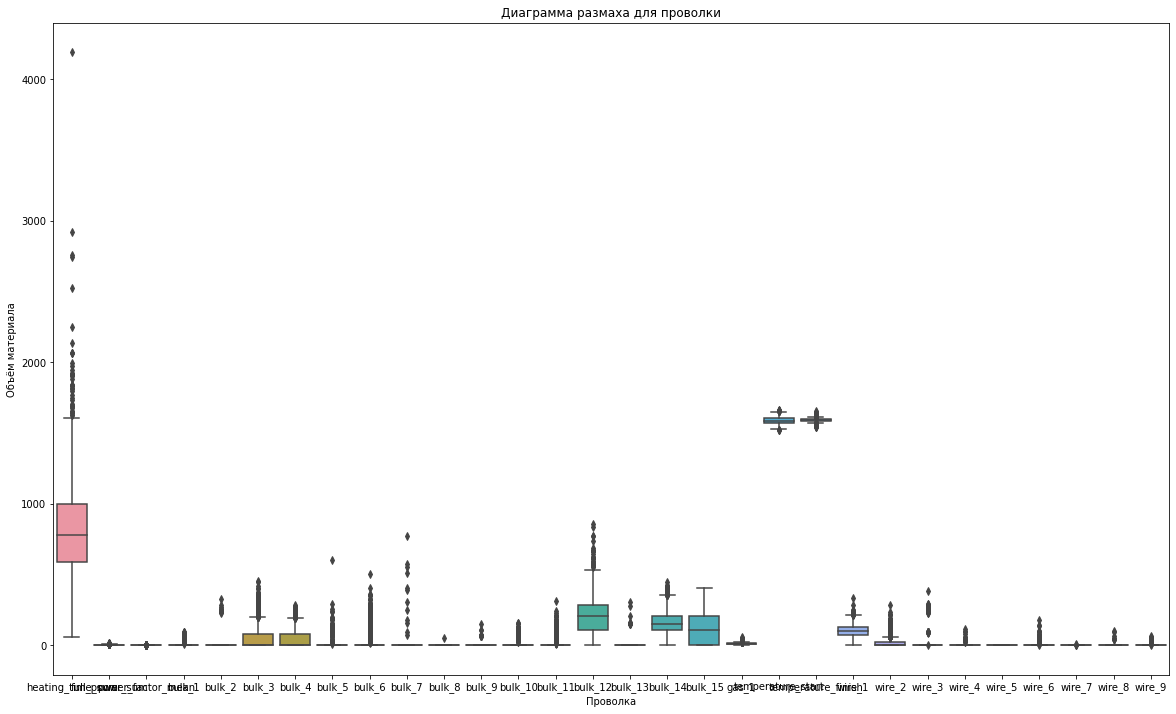

In [109]:
fig = plt.figure(figsize = (20,12))
sns.boxplot(data=data_total[data_total.columns[1:]])
plt.title('Диаграмма размаха для проволки')
plt.xlabel('Проволка')
plt.ylabel('Объём материала')
plt.show()
None

In [110]:
data_total.describe()

,key,heating_time_sum,full_power_sum,power_factor_mean,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1,temperature_start,temperature_finish,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000,2290.0,2290.000000,2290.000000,2290.000000,2290.000000
mean,1249.059825,808.566812,3.885183,0.805459,3.361572,1.446725,47.664629,37.150655,2.685153,22.545415,1.861572,0.021397,0.452402,5.090393,4.153275,208.071616,1.085590,153.875983,120.247162,11.370307,1587.283843,1593.366812,102.487392,17.651897,3.289882,0.311771,0.0,0.995490,0.006469,0.316613,0.322514
std,715.065987,339.169053,1.513984,0.013930,11.839959,19.243082,75.573007,58.672704,22.589659,56.057917,29.760285,1.023949,6.273138,20.968556,22.272442,153.506184,14.355123,80.987518,84.707185,6.250867,23.747373,11.171718,43.613283,33.627891,28.176707,4.797936,0.0,8.766098,0.207448,4.439866,3.485633
min,1.000000,57.000000,0.331897,0.739789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,1519.000000,1541.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,627.250000,585.000000,2.847996,0.796798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,7.300649,1571.000000,1587.000000,73.227958,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1250.500000,780.000000,3.771361,0.806019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.106744,1587.000000,1593.000000,101.081759,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1863.750000,995.000000,4.770418,0.814770,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,281.000000,0.000000,204.000000,204.000000,14.221406,1603.000000,1598.000000,128.086140,23.125181,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,4189.000000,15.288271,0.857042,94.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,853.000000,305.000000,450.000000,405.000000,60.935689,1660.000000,1653.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


- Мы получили датасет состоящий из 31 признака и 2291 измерения (количество партий). 
- Признак 'wire_5' имеет только нулевые значения. Соответственно он не влияет на результат - удалим его.

In [111]:
data_total = data_total.drop(['wire_5'], axis=1)

In [112]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2290 entries, 0 to 2289
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2290 non-null   int64  
 1   heating_time_sum    2290 non-null   int64  
 2   full_power_sum      2290 non-null   float64
 3   power_factor_mean   2290 non-null   float64
 4   bulk_1              2290 non-null   float64
 5   bulk_2              2290 non-null   float64
 6   bulk_3              2290 non-null   float64
 7   bulk_4              2290 non-null   float64
 8   bulk_5              2290 non-null   float64
 9   bulk_6              2290 non-null   float64
 10  bulk_7              2290 non-null   float64
 11  bulk_8              2290 non-null   float64
 12  bulk_9              2290 non-null   float64
 13  bulk_10             2290 non-null   float64
 14  bulk_11             2290 non-null   float64
 15  bulk_12             2290 non-null   float64
 16  bulk_1

**Проверим признаки на мультиколлиниарность.** Пострим тепловую диаграммму и рассчитаем коэфиициент корреляции.

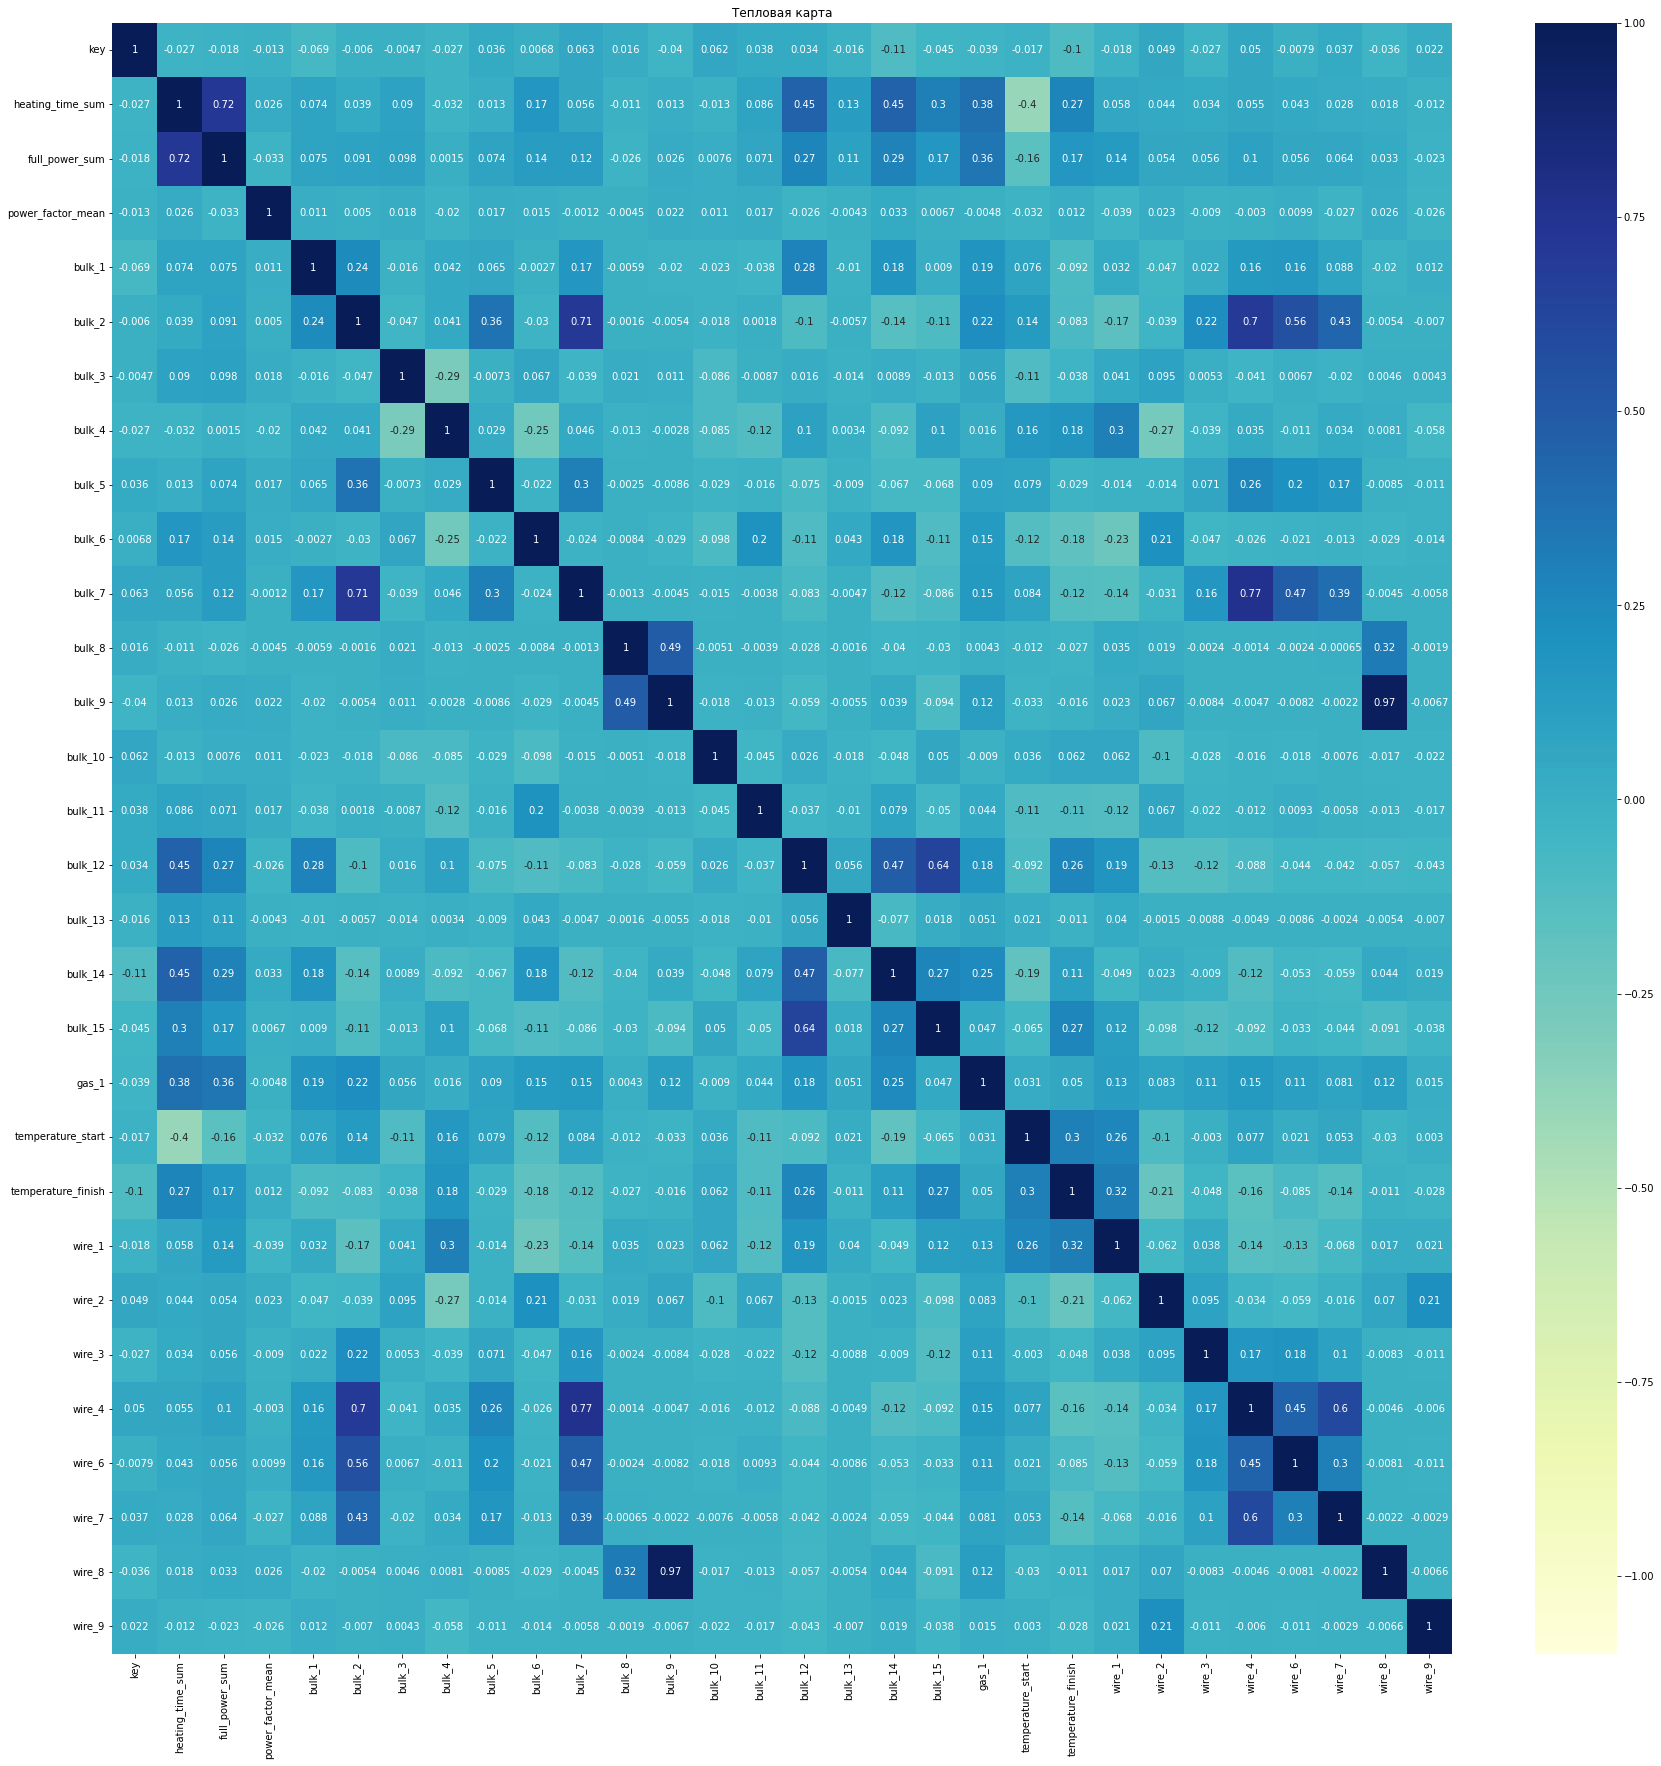

In [113]:
plt.figure(figsize=(30,30))
sns.heatmap(data_total.corr(), vmax=-1, vmin=1, annot=True, cmap='YlGnBu')
plt.title('Тепловая карта')
plt.show()

Из диаграммы видно, что в нашем датасете есть признаки с высоким коэффициентом корреляции.
Рассмотрим призкаки имеющие коэффициент корреляции выше 0.7:
- bulk_9 и wire_8  коэффициент корреляции 0,97
- heating_time_sum  и full_power_sum  коэффициент корреляции 0,72
- wire_4  и bulk_7 коэффициент корреляции 0,77
- wire_4  и bulk_2 коэффициент корреляции 0,7
- bulk_2  и bulk_7 коэффициент корреляции 0,7

Избавимся от лишних признаков: 'wire_4', 'wire_8', 'bulk_2' и 'full_power_sum'. Так же признак 'key'- номер партии нам не понадобится для создания модели.

In [114]:
data_total = data_total.drop(['wire_4', 'wire_8', 'bulk_2', 'full_power_sum', 'key'], axis=1)

In [115]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2290 entries, 0 to 2289
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   heating_time_sum    2290 non-null   int64  
 1   power_factor_mean   2290 non-null   float64
 2   bulk_1              2290 non-null   float64
 3   bulk_3              2290 non-null   float64
 4   bulk_4              2290 non-null   float64
 5   bulk_5              2290 non-null   float64
 6   bulk_6              2290 non-null   float64
 7   bulk_7              2290 non-null   float64
 8   bulk_8              2290 non-null   float64
 9   bulk_9              2290 non-null   float64
 10  bulk_10             2290 non-null   float64
 11  bulk_11             2290 non-null   float64
 12  bulk_12             2290 non-null   float64
 13  bulk_13             2290 non-null   float64
 14  bulk_14             2290 non-null   float64
 15  bulk_15             2290 non-null   float64
 16  gas_1 

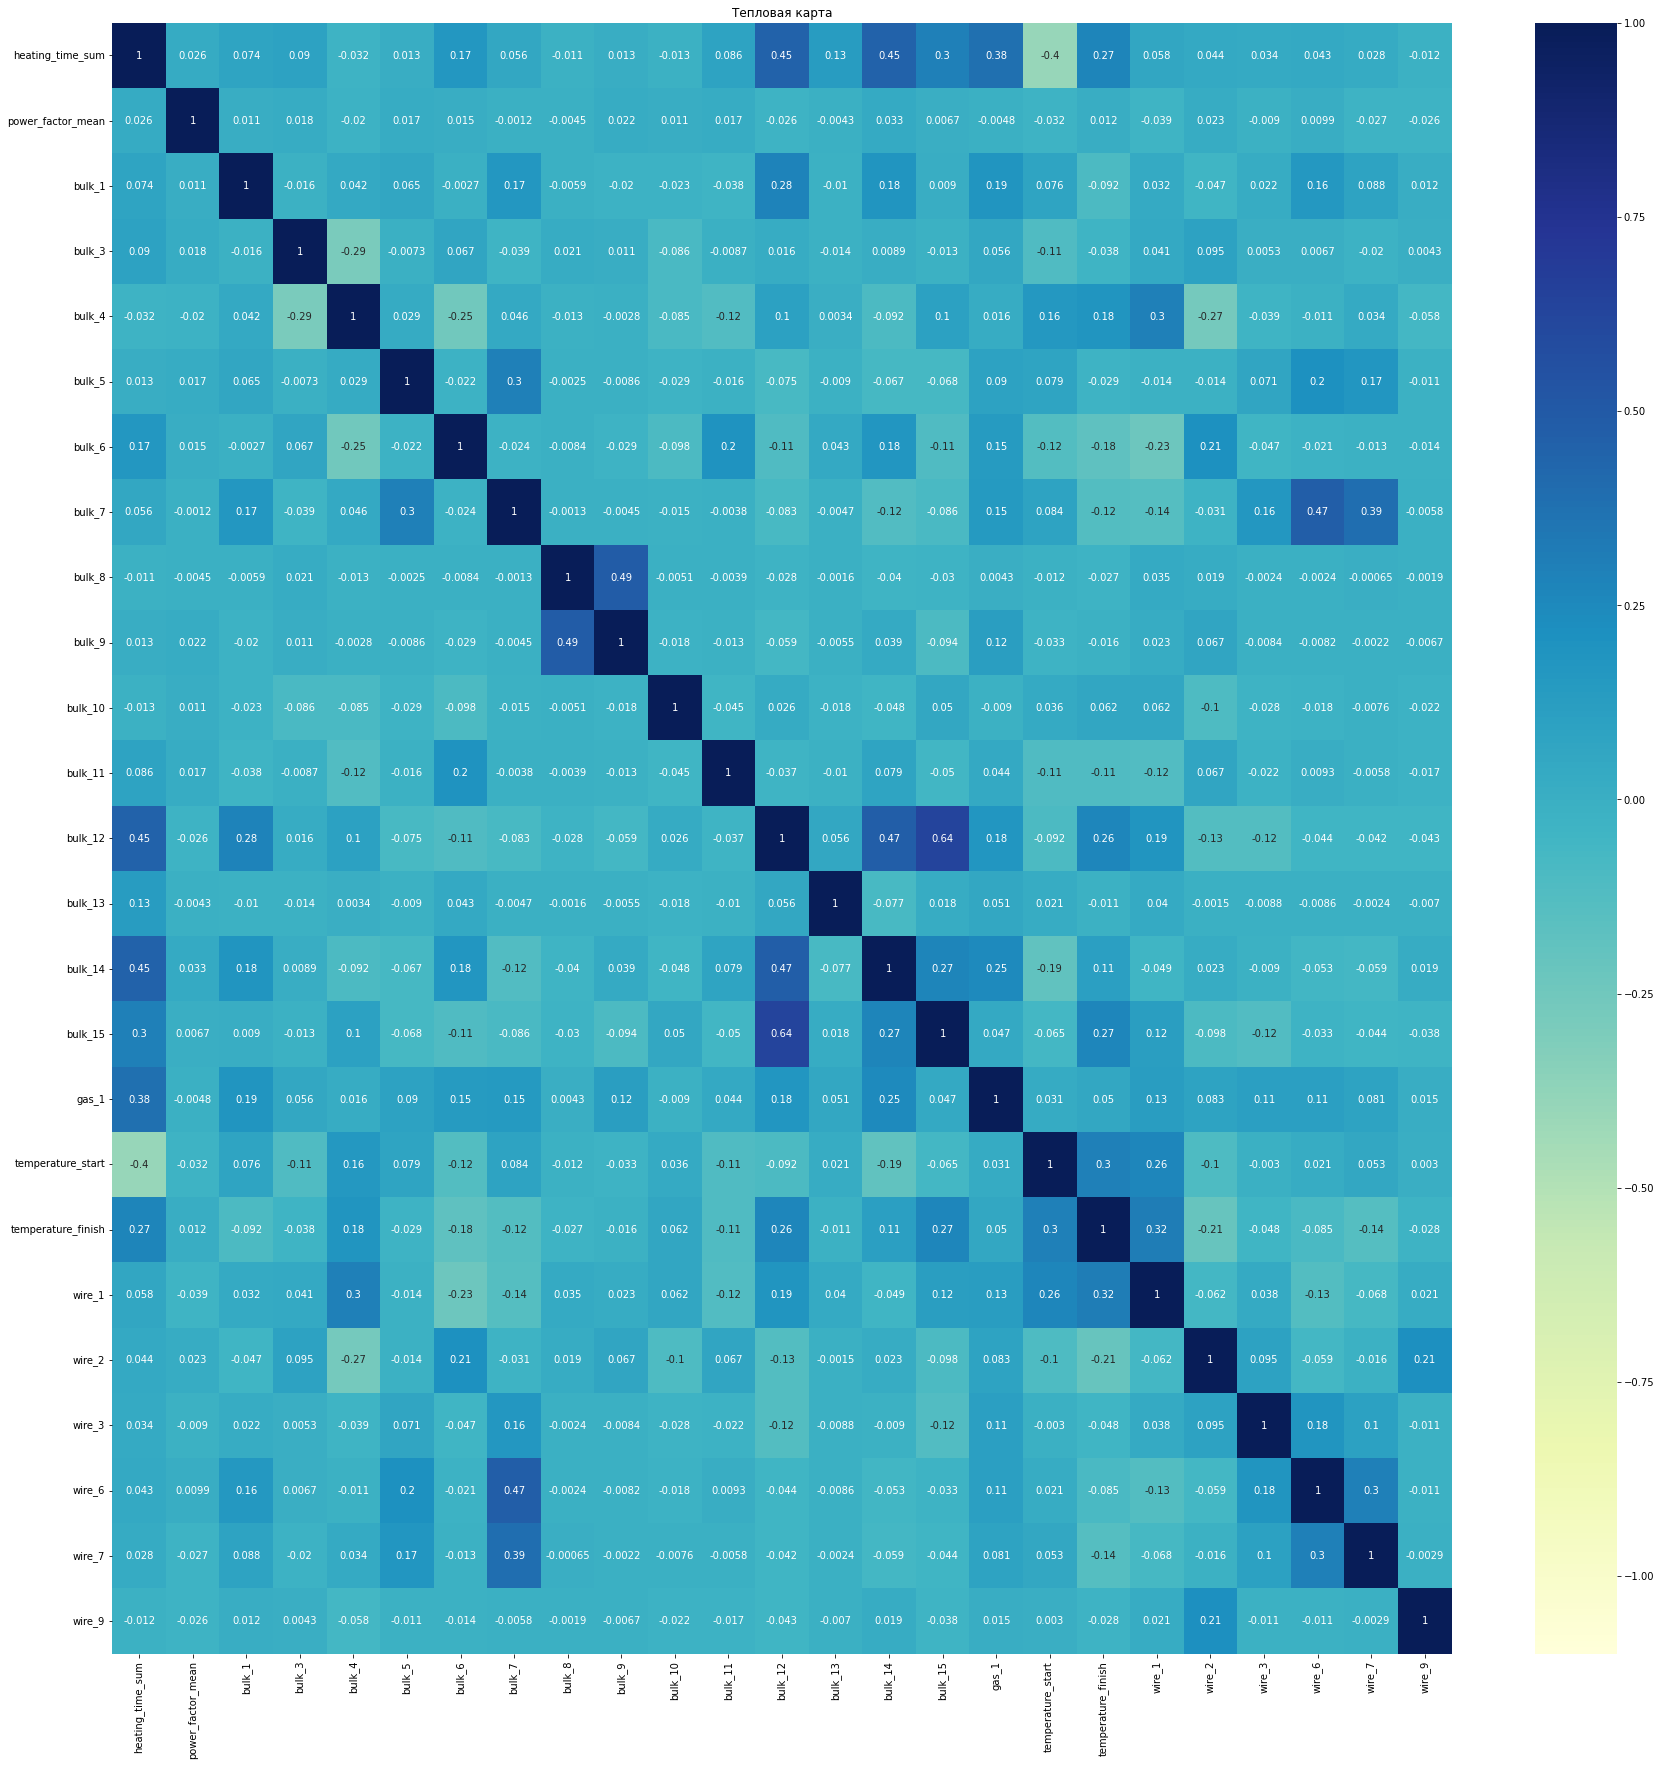

In [116]:
plt.figure(figsize=(30,30))
sns.heatmap(data_total.corr(), vmax=-1, vmin=1, annot=True, cmap='YlGnBu')
plt.title('Тепловая карта')
plt.show()

In [117]:
data_total.head(5)

,heating_time_sum,power_factor_mean,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1,temperature_start,temperature_finish,wire_1,wire_2,wire_3,wire_6,wire_7,wire_9
0,1098,0.816686,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,1571.0,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0
1,811,0.825276,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1581.0,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0
2,655,0.809724,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1596.0,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0
3,741,0.793923,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,1601.0,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0
4,869,0.796818,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,1576.0,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0


In [118]:
data_total.duplicated().sum()

0

Таким образом мы получили датасет без дубликатов и без сильно коррелирующих признаков для создания модели.

### Разделение данных на тестовую и тренировочную выборку

In [119]:
random_state = 220523

Выделим целевой признак 'temperature_finish' и признаки и разобъём выборку на тестовую и тренировочную в соотношении 25:75

In [120]:
target = data_total['temperature_finish']
features = data_total.drop(['temperature_finish'], axis=1)

In [121]:
# разделим на тестовую и тренировочную 
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, test_size=0.25,
                                                                            random_state=random_state)

Оценим размеры выборкок.

In [122]:
features_train.shape

(1717, 24)

In [123]:
features_test.shape

(573, 24)

In [124]:
target_train.shape

(1717,)

In [125]:
target_test.shape

(573,)

In [126]:
features_train.head(5)

,heating_time_sum,power_factor_mean,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1,temperature_start,wire_1,wire_2,wire_3,wire_6,wire_7,wire_9
421,423,0.801888,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,105.0,0.0,0.0,0.0,0.0,0.0,4.392713,1599.0,139.978790,30.160000,0.0,0.0,0.0,0.0
2160,340,0.793123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,155.0,0.0,144.0,102.0,6.795353,1617.0,79.978081,0.000000,0.0,0.0,0.0,0.0
1406,1006,0.810561,46.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,306.0,0.0,152.0,104.0,4.197461,1561.0,98.139603,45.149521,0.0,0.0,0.0,0.0
1835,790,0.784137,0.0,0.0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.145643,1572.0,98.105286,0.000000,0.0,0.0,0.0,0.0
697,434,0.790444,0.0,132.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163.0,0.0,7.461691,1609.0,103.849198,0.000000,0.0,0.0,0.0,0.0


In [127]:
features_test.head(5)

,heating_time_sum,power_factor_mean,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1,temperature_start,wire_1,wire_2,wire_3,wire_6,wire_7,wire_9
1449,1042,0.810749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,414.0,0.0,351.0,206.0,10.596719,1543.0,0.000000,25.093119,0.0,0.0,0.0,0.0
269,1103,0.814302,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,105.0,204.0,13.306863,1572.0,117.193444,12.143040,0.0,0.0,0.0,0.0
957,1992,0.807351,0.0,0.0,243.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,462.0,0.0,210.0,205.0,16.447339,1554.0,121.165196,0.000000,0.0,0.0,0.0,0.0
447,517,0.801070,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,105.0,204.0,15.622281,1609.0,120.042000,0.000000,0.0,0.0,0.0,0.0
326,950,0.798381,0.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,105.0,0.0,263.0,0.0,10.764240,1568.0,72.212395,0.000000,0.0,0.0,0.0,0.0


In [128]:
skim(features_test)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 573    │ │ float64     │ 23    │                                                          │
│ │ Number of columns │ 24     │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA   ┃ NA %   ┃ mean   ┃ sd       ┃ p0     ┃ p25    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ heating_time_sum         │    0 │      0 │    790 │      360 │    110 │    560 │    960 │   2900 │   ▄█▂   │  │
│ │ power_factor_mean        │    0 │      0 │   0.81 │    0.014 │   0.76 │    0.8 │   0.82 │   0.86 │  ▁▃█▆▁  │  │
│ │ bulk_1                   │    0 │      0 │    3.3 │       11 │      0 │      0 │      0 │     92 │    █    │  │
│ │ bulk_3                   │    0 │      0 │     41 │       69 │      0 │      0 │     69 │    370 │   █▂▁   │  │
│ │ bulk_4                   │    0 │      0 │     39 │       59 │      0 │      0 │     81 │    280 │  █▁▁▁   │  │
│ │ bulk_5                   │    0 │      0 │    1.7 │       17 │      0 │      0 │      0 │    290 │    █    │  │
│ │ bulk_6                   │    0 │      0 │     26 │       61 │      0 │      0 │      0 │    500 │   █▁    │  │
│ │ bulk_7                   │    0 │      0 │   0.97 │       23 │      0 │      0 │      0 │    550 │    █    │  │
│ │ bulk_8                   │    0 │      0 │      0 │        0 │      0 │      0 │      0 │      0 │     █   │  │
│ │ bulk_9                   │    0 │      0 │   0.67 │      7.3 │      0 │      0 │      0 │    110 │    █    │  │
│ │ bulk_10                  │    0 │      0 │    4.7 │       19 │      0 │      0 │      0 │    160 │    █    │  │
│ │ bulk_11                  │    0 │      0 │    4.7 │       24 │      0 │      0 │      0 │    310 │    █    │  │
│ │ bulk_12                  │    0 │      0 │    210 │      150 │      0 │    100 │    280 │    780 │  ▆█▂▃   │  │
│ │ bulk_13                  │    0 │      0 │    1.4 │       14 │      0 │      0 │      0 │    160 │    █    │  │
│ │ bulk_14                  │    0 │      0 │    160 │       81 │      0 │    110 │    200 │    450 │  ▂█▇▂▁  │  │
│ │ bulk_15                  │    0 │      0 │    120 │       84 │      0 │      0 │    200 │    400 │  ▇▇▃█   │  │
│ │ gas_1                    │    0 │      0 │     11 │      5.8 │   0.99 │    7.1 │     14 │     42 │  ▅█▃▁   │  │
│ │ temperature_start        │    0 │      0 │   1600 │       23 │   1500 │   1600 │   1600 │   1700 │ ▁▃█▇▃▁  │  │
│ │ wire_1                   │    0 │      0 │    100 │       41 │      0 │     70 │    130 │    240 │  ▂▆█▅▂  │  │
│ │ wire_2                   │    0 │      0 │     21 │       40 │      0 │      0 │     25 │    280 │   █▁    │  │
│ │ wire_3                   │    0 │      0 │    2.1 │       22 │      0 │      0 │      0 │    280 │    █    │  │
│ │ wire_6                   │    0 │      0 │   0.92 │      9.6 │      0 │      0 │      0 │    150 │    █    │  │
│ │ wire_7                   │    0 │      0 │      0 │ 

In [129]:
target_test.describe()

count     573.000000
mean     1593.022688
std        10.945087
min      1556.000000
25%      1587.000000
50%      1592.000000
75%      1598.000000
max      1642.000000
Name: temperature_finish, dtype: float64

In [130]:
target_train.describe()

count    1717.000000
mean     1593.481654
std        11.247136
min      1541.000000
25%      1588.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: temperature_finish, dtype: float64

Разбивка прошла корректно.

### Масштабирование признаков

Итоговой таблице не содержит дубликатов, пропусков и выбрасов. Построим pipline выполняющий следующие шаги:

    - Масштабирование признаков
    - подбор подходящей модели

In [131]:
pipeline = Pipeline([('scaler', StandardScaler())])


In [132]:
pipeline.fit_transform(features_train,target_train)

array([[-1.17310158, -0.25127854, -0.28282146, ..., -0.12051597,
        -0.03602592, -0.08755492],
       [-1.42240351, -0.88090478, -0.28282146, ..., -0.12051597,
        -0.03602592, -0.08755492],
       [ 0.5780192 ,  0.37177017,  3.55594893, ..., -0.12051597,
        -0.03602592, -0.08755492],
       ...,
       [ 0.55699373,  0.44396239, -0.28282146, ..., -0.12051597,
        -0.03602592, -0.08755492],
       [-1.49749445, -0.20139348, -0.28282146, ..., -0.12051597,
        -0.03602592, -0.08755492],
       [-0.680505  ,  0.4684394 , -0.28282146, ..., -0.12051597,
        -0.03602592, -0.08755492]])

In [133]:
train_x_scaler = pipeline.fit_transform(features_train, target_train)

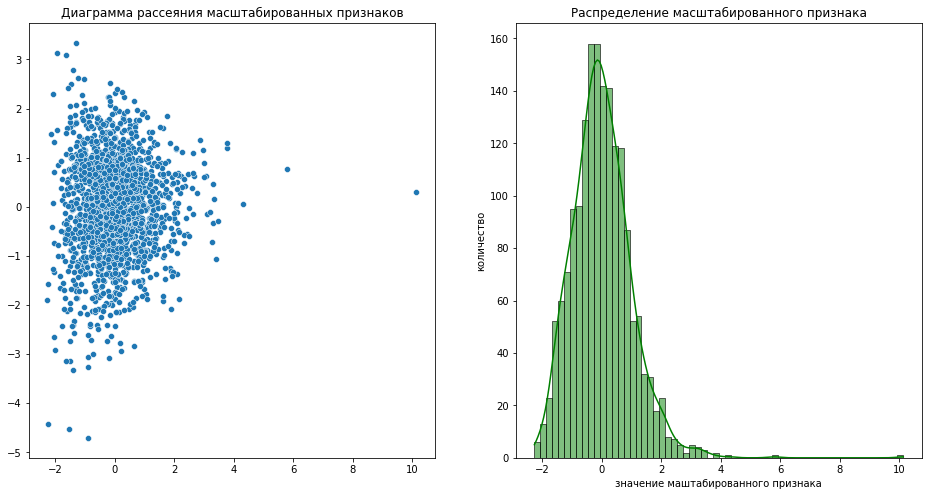

In [134]:
# визуализируем полученное распределение
display(HTML(f'<br><b> Распределение отмаштабированных признаков:</b>'))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
sns.scatterplot(x=train_x_scaler[:,0], y= train_x_scaler[:,1], ax=ax[0])
ax[0].set(title='Диаграмма рассеяния масштабированных признаков')
sns.histplot(x=train_x_scaler[:,0], ax=ax[1], kde=True, color='g')
ax[1].set(title='Распределение масштабированного признака')
ax[1].set(xlabel='значение маштабированного признака', ylabel='количество')
plt.show()

In [135]:
pipeline

Pipeline(steps=[('scaler', StandardScaler())])

### Модели

Рассмотрим модели:
   - DummyRegressor - для проверки работы модели
   - LinearRegression - линейная регрессия
   - RandomForestRegressor - случайный лес
   - CatBoostRegressor
   
Для модели DummyRegressor  будем использовать кросс-валидацию.
   
Для моделей LinearRegression, RandomForestRegressor и CatBoostRegressor проведём подбор параметров с помощью RandomizedSearchCV.



 **DummyRegressor**

In [136]:
# добавим в pipeline DummyRegressor со стратегией заполнения средним значением
pipeline.steps.append(('reg', DummyRegressor(strategy='mean')))
pipeline

Pipeline(steps=[('scaler', StandardScaler()), ('reg', DummyRegressor())])

In [137]:
pipeline.fit(features_train, target_train)

Pipeline(steps=[('scaler', StandardScaler()), ('reg', DummyRegressor())])

In [138]:
# рассчитаем МАЕ для DummyRegressor
mae_DR = round(mean_absolute_error(target_train, pipeline.predict(features_train)),2)

In [139]:
print('MAE модеди DummyRegressor:', mae_DR)

MAE модеди DummyRegressor: 8.03


In [140]:
DR_result = pd.DataFrame({'model': ['DummyRegressor'],
 'mean_test_score': [mae_DR]})
DR_result

,model,mean_test_score
0,DummyRegressor,8.03


 **LinearRegression, RandomForestRegressor, CatBoostRegressor**

In [141]:
# с момощью RandomizedSearchCV() осуществим подбор гиперпараметров на кроссвалидации

params =[{
        'reg': [LinearRegression()],
        'reg__fit_intercept': ['True','False'],
        'reg__copy_X': ['True','False'],
        'reg__normalize': [True,False]
    },
    {
        'reg': [RandomForestRegressor(random_state = random_state)],
        'reg__n_estimators': [2,10,100,200],
        'reg__max_depth':(3,25,2),
        'reg__max_features':[None,'sqrt',5],
        'reg__min_samples_leaf': [2,4,8]
    },
    {
        'reg': [CatBoostRegressor(random_state = random_state, loss_function = 'MAE', verbose = 0)],
        'reg__depth': (1,10,2),
        'reg__learning_rate': [0.05,0.1,0.5],
        'reg__iterations': [100,200,350,500]
    }
]

In [142]:
grid = RandomizedSearchCV(pipeline,
                         params,
                         n_iter = 30,
                         cv = 3,
                         verbose = 1,
                         random_state = random_state,
                         scoring = 'neg_mean_absolute_error',
                         n_jobs = -1)

In [143]:
%%time
grid.fit(features_train, target_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/tatianabeliaeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'norm

CPU times: user 1.31 s, sys: 297 ms, total: 1.6 s
Wall time: 54.3 s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('reg', DummyRegressor())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions=[{'reg': [LinearRegression()],
                                         'reg__copy_X': ['True', 'False'],
                                         'reg__fit_intercept': ['True',
                                                                'False'],
                                         'reg__normalize': [True, False]},
                                        {'reg': [RandomForestRegressor(random_state=220523)],
                                         'reg__max_depth': (3, 25, 2),
                                         'reg__max_features': [None, 'sqrt', 5],
                                         'reg__min_samples_leaf': [2, 4, 8],
                                         'reg__n_estimators': [2, 10, 100,
                     

In [144]:
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('reg',
                 <catboost.core.CatBoostRegressor object at 0x7fe4bd2caa30>)])

In [145]:
print('Список лучших гиперпарамметров:\n', grid.best_params_)

Список лучших гиперпарамметров:
 {'reg__learning_rate': 0.1, 'reg__iterations': 500, 'reg__depth': 2, 'reg': <catboost.core.CatBoostRegressor object at 0x7fe4bd69e9d0>}


In [146]:
print('Лучшая метрика MAE на кроссвалидации', round(abs(grid.best_score_),2))

Лучшая метрика MAE на кроссвалидации 6.11


In [147]:
# Соберём из результатов работы RandomizedSearchCV датафрейм
cv_results = pd.DataFrame(grid.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)

# выберем интересующие нас столбцы
cols = ['rank_test_score', 'param_reg', 'params', 'mean_test_score', 'std_test_score']

# посмотрим датафрейм с этими результатами
df_results = cv_results[cols].sort_values(by = 'rank_test_score')
display(df_results)

,rank_test_score,param_reg,params,mean_test_score,std_test_score
10,1,<catboost.core.CatBoostRegressor object at 0x7...,"{'reg__learning_rate': 0.1, 'reg__iterations':...",-6.108536,0.026160
15,2,<catboost.core.CatBoostRegressor object at 0x7...,"{'reg__learning_rate': 0.1, 'reg__iterations':...",-6.293668,0.020287
2,3,LinearRegression(),"{'reg__normalize': False, 'reg__fit_intercept'...",-6.373598,0.110971
18,4,LinearRegression(),"{'reg__normalize': True, 'reg__fit_intercept':...",-6.373598,0.110971
4,5,<catboost.core.CatBoostRegressor object at 0x7...,"{'reg__learning_rate': 0.05, 'reg__iterations'...",-6.460203,0.139501
25,6,<catboost.core.CatBoostRegressor object at 0x7...,"{'reg__learning_rate': 0.05, 'reg__iterations'...",-6.464769,0.033206
28,7,RandomForestRegressor(random_state=220523),"{'reg__n_estimators': 100, 'reg__min_samples_l...",-6.504647,0.092563
5,8,<catboost.core.CatBoostRegressor object at 0x7...,"{'reg__learning_rate': 0.1, 'reg__iterations':...",-6.526543,0.040443
19,9,RandomForestRegressor(random_state=220523),"{'reg__n_estimators': 200, 'reg__min_samples_l...",-6.531846,0.121379
13,10,<catboost.core.CatBoostRegressor object at 0x7...,"{'reg__learning_rate': 0.1, 'reg__iterations':...",-6.543582,0.061448


In [148]:
# Лучшие параметры каждой модели
df_results['model'] = df_results['param_reg'].apply(lambda x: str(type(x))[:-2].split('.')[-1])
best_params = df_results.groupby('model', as_index=False).agg({'mean_test_score':max})
best_params['mean_test_score'] = abs(best_params['mean_test_score'])



best_params = pd.concat([best_params, DR_result], ignore_index=True)

best_params.sort_values(by='mean_test_score')


,model,mean_test_score
0,CatBoostRegressor,6.108536
1,LinearRegression,6.373598
2,RandomForestRegressor,6.504647
3,DummyRegressor,8.030000


Было проведено исследование моделей 'DummyRegressor','LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor':
 - подобраны к ним гиперпараметры
 - рассчитаны наилучшие значения метрики MAE 

Лучший результат показала модели CatBoostRegressor MAE=6.11 с параметрами 'learning_rate': 0.1, 'iterations': 500, 'depth': 2.  Выберем эту модель, как лучшую и проверим на ней тестовую выборку.


In [149]:
print('MAE для  лучшей модели на тестовой выборке:', round(mean_absolute_error(target_test, grid.predict(features_test)),2))

MAE для  лучшей модели на тестовой выборке: 6.14


### Оценка важности признаков для лучшей модели

In [150]:
feature_names = features_train.columns

In [151]:
features_train=pd.DataFrame(features_train, columns = feature_names)
features_train.head()

,heating_time_sum,power_factor_mean,bulk_1,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1,temperature_start,wire_1,wire_2,wire_3,wire_6,wire_7,wire_9
421,423,0.801888,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,105.0,0.0,0.0,0.0,0.0,0.0,4.392713,1599.0,139.978790,30.160000,0.0,0.0,0.0,0.0
2160,340,0.793123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,155.0,0.0,144.0,102.0,6.795353,1617.0,79.978081,0.000000,0.0,0.0,0.0,0.0
1406,1006,0.810561,46.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,306.0,0.0,152.0,104.0,4.197461,1561.0,98.139603,45.149521,0.0,0.0,0.0,0.0
1835,790,0.784137,0.0,0.0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.145643,1572.0,98.105286,0.000000,0.0,0.0,0.0,0.0
697,434,0.790444,0.0,132.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163.0,0.0,7.461691,1609.0,103.849198,0.000000,0.0,0.0,0.0,0.0


Построим график отражающий важность признаков

0:	learn: 11.1075357	total: 866us	remaining: 432ms
1:	learn: 10.9336899	total: 1.59ms	remaining: 395ms
2:	learn: 10.8130509	total: 2.16ms	remaining: 358ms
3:	learn: 10.7138054	total: 2.72ms	remaining: 337ms
4:	learn: 10.6342789	total: 3.32ms	remaining: 328ms
5:	learn: 10.4999269	total: 4ms	remaining: 329ms
6:	learn: 10.3712225	total: 4.66ms	remaining: 328ms
7:	learn: 10.2782856	total: 5.28ms	remaining: 325ms
8:	learn: 10.1984573	total: 5.99ms	remaining: 327ms
9:	learn: 10.1335044	total: 6.77ms	remaining: 332ms
10:	learn: 10.0404327	total: 7.56ms	remaining: 336ms
11:	learn: 9.9693834	total: 8.59ms	remaining: 349ms
12:	learn: 9.9063890	total: 9.31ms	remaining: 349ms
13:	learn: 9.8444299	total: 10.1ms	remaining: 352ms
14:	learn: 9.7915126	total: 10.8ms	remaining: 348ms
15:	learn: 9.7367576	total: 11.5ms	remaining: 349ms
16:	learn: 9.6864023	total: 12.1ms	remaining: 345ms
17:	learn: 9.6583282	total: 12.6ms	remaining: 338ms
18:	learn: 9.6241751	total: 13.2ms	remaining: 334ms
19:	learn: 9.58

198:	learn: 7.3667961	total: 132ms	remaining: 200ms
199:	learn: 7.3631196	total: 134ms	remaining: 201ms
200:	learn: 7.3586147	total: 135ms	remaining: 201ms
201:	learn: 7.3564334	total: 136ms	remaining: 201ms
202:	learn: 7.3534135	total: 137ms	remaining: 200ms
203:	learn: 7.3491233	total: 138ms	remaining: 200ms
204:	learn: 7.3467549	total: 138ms	remaining: 199ms
205:	learn: 7.3433914	total: 139ms	remaining: 199ms
206:	learn: 7.3380345	total: 140ms	remaining: 199ms
207:	learn: 7.3291543	total: 141ms	remaining: 198ms
208:	learn: 7.3252308	total: 142ms	remaining: 198ms
209:	learn: 7.3228705	total: 143ms	remaining: 197ms
210:	learn: 7.3194846	total: 143ms	remaining: 196ms
211:	learn: 7.3172439	total: 144ms	remaining: 196ms
212:	learn: 7.3124615	total: 144ms	remaining: 195ms
213:	learn: 7.3098876	total: 145ms	remaining: 194ms
214:	learn: 7.3012283	total: 146ms	remaining: 193ms
215:	learn: 7.2920622	total: 146ms	remaining: 192ms
216:	learn: 7.2848948	total: 147ms	remaining: 192ms
217:	learn: 

356:	learn: 6.8923632	total: 232ms	remaining: 92.9ms
357:	learn: 6.8917511	total: 233ms	remaining: 92.3ms
358:	learn: 6.8888019	total: 233ms	remaining: 91.6ms
359:	learn: 6.8860018	total: 234ms	remaining: 90.9ms
360:	learn: 6.8837623	total: 234ms	remaining: 90.3ms
361:	learn: 6.8820504	total: 235ms	remaining: 89.6ms
362:	learn: 6.8815134	total: 236ms	remaining: 88.9ms
363:	learn: 6.8784090	total: 236ms	remaining: 88.2ms
364:	learn: 6.8770694	total: 237ms	remaining: 87.5ms
365:	learn: 6.8747536	total: 237ms	remaining: 86.9ms
366:	learn: 6.8729722	total: 238ms	remaining: 86.2ms
367:	learn: 6.8710668	total: 238ms	remaining: 85.5ms
368:	learn: 6.8659544	total: 239ms	remaining: 84.8ms
369:	learn: 6.8654582	total: 239ms	remaining: 84.1ms
370:	learn: 6.8640276	total: 240ms	remaining: 83.5ms
371:	learn: 6.8620968	total: 241ms	remaining: 82.8ms
372:	learn: 6.8564402	total: 241ms	remaining: 82.1ms
373:	learn: 6.8554873	total: 242ms	remaining: 81.4ms
374:	learn: 6.8531204	total: 242ms	remaining: 

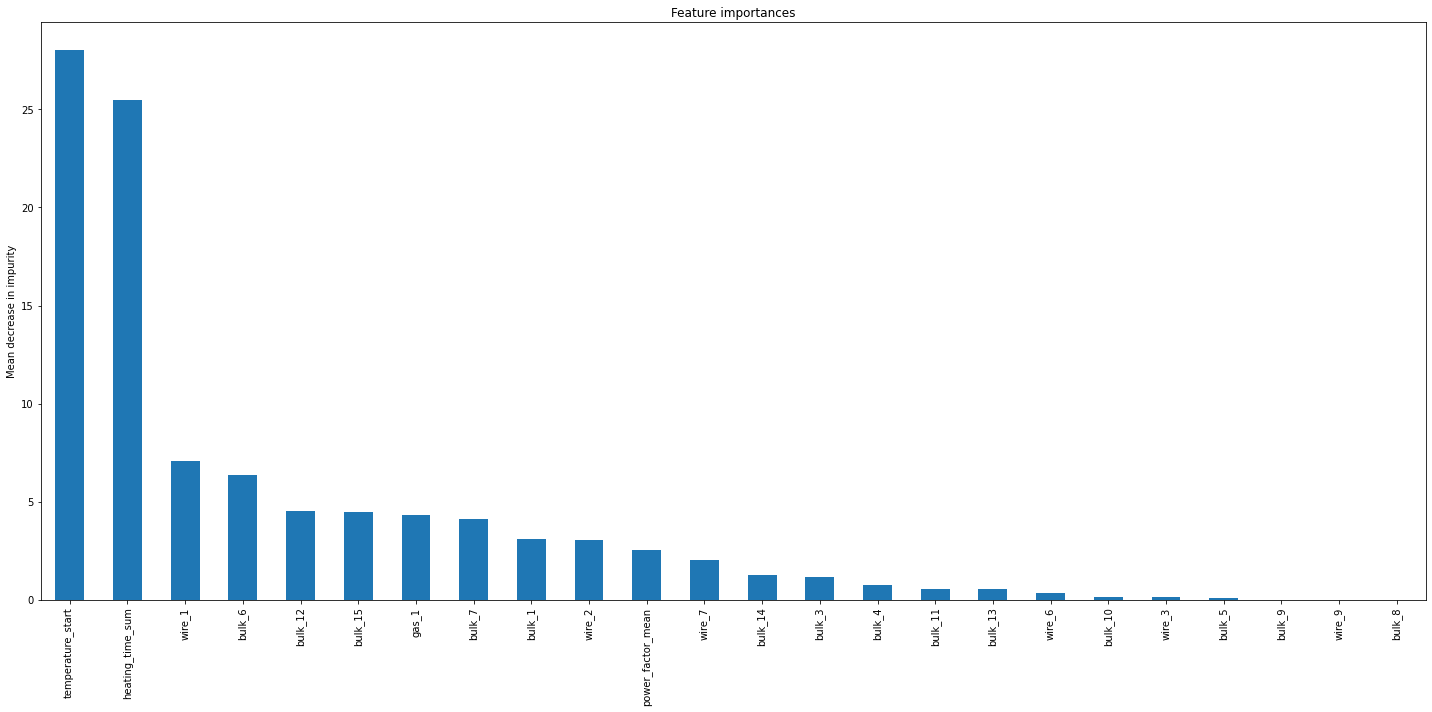

In [152]:
model = CatBoostRegressor(depth = 2, iterations = 500, learning_rate = 0.1)
model.fit(features_train, target_train)
pred = model.predict(features_test)
importances = model.feature_importances_
best_model_importances = pd.Series(importances, index=feature_names)


std = np.std([model.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(20,10))
best_model_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Из графика видно, что признаки temperature_start - начальная температура, hearting_time_sum - суммарное время нагрева, wire_1  - являются наиболее важными.

### Вывод

- Была создана финальная таблица: объединили имеющиеся у нас таблицы в одну по ключу: так что в датасет вошли только те ключи, которые есть во всех таблицах: data_arc_total, data_bulk, data_gas, data_temp_total, data_wire. Датасеты с временными данными не были включены.

- Из диаграммы видно, что в нашем датасете есть признаки с высоким коэффициентом корреляции.

Рассмотрены призкаки имеющие коэффициент корреляции от 0.7:
- bulk_9 и wire_8  коэффициент корреляции 0,97
- heating_time_sum  и full_power_sum  коэффициент корреляции 0,72
- wire_4  и bulk_7 коэффициент корреляции 0,77
- wire_4  и bulk_2 коэффициент корреляции 0,7
- bulk_2  и bulk_7 коэффициент корреляции 0,71
Избавимся от лишних признаков: 'wire_4', 'wire_8', 'bulk_2' и 'full_power_sum'. Так же признак 'key'- номер партии нам не понадобится для создания модели.

- Созданы модели:
   - DummyRegressor - для проверки работы модели
   - LinearRegression - линейная регрессия
   - RandomForestRegressor - случайный лес
   - CatBoostRegressor
- Модель DummyRegressor обучена с помощью кросс-валидации.
- Для моделей LinearRegression, RandomForestRegressor и CatBoostRegressor проведём подбор параметров с помощью RandomizedSearchCV.
- Было проведено исследование моделей 'DummyRegressor','LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor':
   - подобраны к ним гиперпараметры
   - рассчитаны наилучшие значения метрики MAE 


- Определили лучшую модель. Ей оказалась модель CatBoostRegressor с параметрами 'learning_rate': 0.1, 'iterations': 500, 'depth': 2.  MAE=6.10. 
- На лучшей модели была проверена тестовая выборка. Результат MAE 6.14.
- Была проведена оценка важности признаков для лучшей модели. Признаки temperature_start - начальная температура  hearting_time_sum - суммарное время нагрева, wire_1 - являются наиболее важными.

## Отчёт для заказчика

1) Цель проекта: предсказание финальной температуру стали, которая в дальнейшем позволит уменьшить потребление электроэнергии на этапе обработки стали. Метрика MAE должна быть меньше 6.8.

2) План работы:
   1. Узучение информацию о представленных датасетах: данные об электродах, данные о подаче сыпучих и проволочных материалов (объём и время подачи), данные о продувке сплава газом и данные о результатах измерения температуры.
   2. Подготовка данных: заполним пропуски, сформируем новые признаки.
   3. Формирование единой таблицы признаков.
   4. Проверка признаков на кореляцию.
   5. Разделение данных на тренировочную и тестовую выборки в соотношении 75:25
   6. Масштабирование признаков.
   7. Обучение моделей и подбор оптимальных параметров с помощью RamdomizedSearchCV. Модели: линейная регрессия, случайный лес, Catboost.
   8. Выбор наилучшую модели. Проверка её на тестовой выборке.
   9. Анализ важности признаков.
   10. Отчёт для заказчика.
Все пункты плана были выполнены. Был добавлен дополнительно рассчёт метрики R2 - коэффициент детерминации. Эта метрика говорит о качестве работы модели. Так же для сравнения была рассчитана метрика MAE для случайной модели DummyRegressor. Других изменений не было.

3) Можно выделить несколько ключевых шаги:
   1. Исследовательский анализ данных: подготовка данных и формирование итоговой таблицы признаков. 
   
       Данные об электродах:
       - Были удалены анамальные значения для реактивной мощности - были удалены полностью партии в которых встречались аномальные значения.
       - Получены графики распределения активной и реактивной мощностей. Их распределение близко к нормальному.
       - Была выявлена корреляция между активной и реактивной мощностями: коэфиициент корреляции равен 0,97.
       - Из имеющихся данных были созданы новые признаки:
             - длительность нагрева (из время начала и время окончания нагрева дуги)
             - полная мощность (квадратный корень из суммы квадратов активной и  реактривной мощностей)
             - коэффициент мощности (отношение активной мощности к полной мощности)
             
  - В имеющихся данных было представлено по несколько измерений для каждой партии. Для предсказания температур нам было необходимо сгруппировать данные по партиям. 
  - Из данных были удалены признаки, которые нам не нужны для предсказания: начало нагрева дуги -'start_of_arc_heating', конец нагрема дуги - 'end_of_arc_heating', активная мощность - 'active_power', реактивная мощность - 'reactive_power'. - Мы получили новую таблицу с 3213 записями по 4 признакам:
            - key - номер партии
            - heating_time_sum - суммарное время нагрева
            - full_power_sum - суммарная полная мощность
            - power_factor_mean - средний коэффициент мощности
      - Пропусков и дубликатов в данных нет.

     Данные о подаче сыпучих  и о проволочных материалов (оъём):
        - В данных было обнаружено большое количество пропусков.
        - Пропуски были заменены значением 0.

     Данные о подаче сыпучих и о проволочных материалов (время)
        - Данные по своей структуре аналогичны данным из таблиц о объёме. 
        - В работе мы не будем исследовать временные ряды, поэтому  оставили эти данные без изменений.

     Данные о продувке сплава газом:
        - пропусков в данных нет, газ использовался в каждой партии
        - дубликатов нет
        - в данных 3229 записей по 2 признака - номер партии и объём газа для продувки
        - данные имеют распределение близкое к нормальному. Есть значения значительно привышающие среднее, но принять решение о наличии анамалии мы не можем, так как не обладаем полной информацией

     Данные о результаты измерения температуры:
        - В данных содержалось 18092 записей по 3 признака: 'key' - партия, 'measurement_time' - время измерения и 'temperature' - температура.
        - Были обнаружены 3427 пропуска в признаке 'temperature' - температура.
        - В данных содержалась информация о нашем целевом признаке - конечная температура.
        - Были обнаружены и удалены выбросы - температура меньше 1500 градусов
        - Был создан новый датафрейм с новыми признаками: целевой признак - последняя температура и признак - начальная температура
        - Целевой признак (конечная температура) имеет распределение близкое к нормальному.


На завершающем этапе по предобработке данных все Dataset были объединены в финальную таблицу по ключу (номер партии) куда попали только те ключи которые есть во всех таблицах. В финальную таблицу попали 2291 измерения (количество партий) и 31 признак: среди которых были неинформативные признаки: номер партии, признак 'wire_5', содержащий только нулевые значения. Они были удалены. Таккже просле исследования признаков на мультиколлериальность были удалены признаки wire_4', 'wire_8', 'bulk_2' и 'full_power_sum' и 'key'.

**В итоге в финальной таблице осталось 25 признака (включая целевой - конечная температура) и 2290 измерения (количество партий).** 

4) При анализе данных возникли затруднения в определении наличия выбросов в данных о подаче сыпучих и проволочных материалов. Это связано с отсутствием информации о том, что из себя представляет каждая из добавок и в приделах какого объёма они могут испрользоваться. Было принято решение оставить выбросы без внимания.

5) После разделения данных на тестоиую и тренировочную выборки в соотвношении 25:75 и выделении целевого признака  в тренировочной выборке осталось **1717 измерений по 24 признака**. 

Список признаков: 

     - heating_time_sum  - длительность нагрева 
     - power_factor_mean - средний коэффициент мощности
     
     - Сыпучие материалы (объём):
         - bulk_1 
         - bulk_3
         - bulk_4
         - bulk_5
         - bulk_6
         - bulk_7
         - bulk_8
         - bulk_9
         - bulk_10
         - bulk_11
         - bulk_12
         - bulk_13
         - bulk_14
         - bulk_15
     - gas_1 - объём продувки газа
     - temperature_start - начальная температура
     - Проволочные материалы (объём):
         - wire_1
         - wire_2
         - wire_3
         - wire_6
         - wire_7
         - wire_9
Так как все признаки являются численными, для всех них проведено масштабирование методом стандартизации.


    2. Обучение моделей, подбор оптимальных параметров и выбор наилучшей модели.
        - Созданы модели:
               - DummyRegressor - для проверки работы модели
               - LinearRegression - линейная регрессия
               - RandomForestRegressor - случайный лес
               - CatBoostRegressor
        - Модели DummyRegressor и LinearRegression обучены с помощью кросс-валидации.
        - Для моделей RandomForestRegressor и CatBoostRegressor проведён подбор параметров с помощью RandomizedSearchCV.
        - Для всех моделей рассчитаны наилучшие значения метрики MAE    
        - Лучшей моделью оказалась модель CatBoostRegressor с параметрами 'learning_rate': 0.1, 'iterations': 500, 'depth': 2  MAE=6.10, random_state = 220523. 
        - На лучшей модели была проверена тестовая выборка. Результат MAE 6.14. Что удовлетворяет требования заказчика.
        
    3. Анализ важности признаков для наилучшей модели.
    - Была проведена оценка важности признаков для лучшей модели. Признаки temperature_start - начальная температура, heating_time_sum - суммарное время нагрева - являются наиболее важными. Важнейшей добавкой является 'wire_1'
   
6) Таким образом нам удалось создать модель предсказывающую конечную температуру сплава. Эта модель в дальнейшем позволит уменьшить потребление электроэнергии и скорректировать объём применяемых материалов на этапе обработки стали.

